Данная тетрадка используется для разработки модели машинного обучения для классификации новых товаров(определение принадлежности товара к конкретной товарной категории из действующего справочника) по наименованию. Для обучения модели берутся данные текущие из справочника.

In [1]:
#!pip install skimpy

In [2]:
# импорт библиотек
import oracledb
import pandas as pd
from pymystem3 import Mystem
import numpy as np
import re
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

#models
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier

import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords

#from skimpy import clean_columns

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A_Rybnikov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# установка констант
RANDOM_STATE=4
stop_words = set(stopwords.words('russian')) 

Набор стоп-слов

In [4]:
stop_words = list(stop_words)

Прописываем коннект до базы RMS

In [6]:
conn = oracledb.connect(user='',
                              password='',
                              host='',
                              port=,
                              sid='')

Запрос для получения информации о справочнике товаров.

In [7]:
sql = "SELECT  im.item,im.item_desc,div.division,g.group_no, im.dept, im.class, im.subclass " \
      "FROM item_master im "\
      "JOIN deps d ON d.dept=im.dept "\
      "JOIN groups g ON d.group_no=g.group_no "\
      "JOIN division div ON div.division=g.division "\
      "WHERE im.item_number_type='ITEM' "\
        "AND im.status='A' " \
        "AND (im.item NOT LIKE '101%' "\
         "AND im.item NOT LIKE '102%' "\
         "AND im.item NOT LIKE '104%')"\
        "AND im.item_desc NOT LIKE '%!%'"

Запрос для получения информации о классификаторе

In [8]:
sql_class = 'select d.division, d.div_name, g.group_no,g.group_name, s.dept,d.dept_name, s.class,c.class_name, s.subclass, s.sub_name '\
'from subclass s '\
'join class c on c.class=s.class '\
'join deps d on d.dept=s.dept '\
'join groups g on g.group_no=d.group_no '\
'join division d on d.division=g.division '\
'where d.division>6'

Оборачиваем в DataFrame справочник и классификатор

In [9]:
classifier = pd.read_sql(sql_class, conn)

In [10]:
items = pd.read_sql(sql, conn)

Соединим классификатор и справочник товаров.

In [11]:
items = items.merge(classifier)

In [12]:
items.rename(columns={i: i.lower() for i in list(items.columns)},inplace=True)
classifier.rename(columns={i: i.lower() for i in list(classifier.columns)},inplace=True)

Удалим из списка товаров товары с !! в названиях

In [13]:
items = items.query('~(item_desc.str.contains("!!") \
                    or div_name.str.contains("!!")\
                    or group_name.str.contains("!!")\
                    or dept_name.str.contains("!!")\
                    or class_name.str.contains("!!")\
                    or sub_name.str.contains("!!"))')

Сразу отделим целевую выборку с подгруппой 5777 от общей выборки.

In [15]:
items_not_classified = items[items['subclass']==5777]

In [16]:
items = items[items['subclass']!=5777]

Смотрим на распределение по секторам

In [17]:
items_not_classified

item                                          item_desc  \
412162  110114412                 Коржи Черока МЕДОВИК 4000г бум/кор   
412163  110114421                 Коржи Черока ПЕСОЧНЫЕ 400г бум/кор   
412164  110114869             Кедровый орех в сосновом сиропе 250гр.   
412165  110114615  ЗУБНАЯ ПАСТА R.O.C.S. BIOCOMPLEX АКТИВНАЯ ЗАЩИ...   
412166  110114623  Шоколад Альпен Гольд вус клубника игристое вин...   
412167  110114720  Молочный шоколад с черной смородиной .облепихо...   
412168  110114738                         Кальмар Командорский тушка   
412169  110114746  Молочный шоколад с брусникой с кедровым орехом...   
412170  110114754  Корм Perfect Fit Immunity говядина/лен/голубик...   
412171  110114762                              Шишка шоколадная 80гр   
412172  110114789  Сосновое варенье из целых шишек с кедровым оре...   
412173  110114797  Сосновое варенье из целых шишек с кедровым оре...   
412174  110114877                     Корнишоны с перец / чили 370мл   
412175  110114658          Суп Ролтон Куриный с вермишелью  50г м/уп   
412176  110114885                        Корнишоны Перец/Чили 370 мл   
412177  110114893                 Вода Мия 033 литра без газа стекло   
412178  110114391                             Филе Форели пл/пак вес   
412179  110114851                      Чипсы яблочные с кокосом 25гр   
412180  110114914                 Гель д/стирки Ласка для тёмного 3л   
412181  110114922                   Кедровый орех в сиропе 50%200 мл   
412182  110114181                           Щековина в/к в/у СибАгро   
412183  110114439                    Сосиски БП (Традиционные )0,5 г   
412184  110114447                         Сосиски БП (С Сыром )0,5 г   
412185  110114199                       Суповой набор из оленины 2кг   
412186  110114201                      \tШоколад Аленка пористый 90г   
412187  110114210            Карамель РотФронт Эвкалипт-ментол 200гр   
412188  110114228  Карамель РотФронт микс кокосовая-арахисовая 200гр   
412189  110114404  Пиво Лобанов Александр светлое нефильтр паст 4...   
412190  110114463   Горошек ЗЕЛЕНАЯ ПРЕМИЯ зеленый молодой с/б 450гр   
412191  110114471  Килька Вкусные Консервы обжареная в т/с с/б 260гр   
412192  110114480  Сосиски Барский продукт Рубачики с рубленым мя...   
412193  110114498  Лосось Вкусные Консервы с овощами по-итал.в то...   
412194  110114586         ЗУБНАЯ ПАСТА SPLAT DAILY ОТБЕЛИВАЮЩАЯ 100г   
412195  110114594  ЗУБНАЯ ПАСТА ЛЕСНОЙ БАЛЬЗАМ Д/ДЕТЕЙ 7+ ЯГОДНЫЙ...   
412196  110114244  Водка ПАРКА Арктическая клюква 0,5л./40% стк. ...   
412197  110114252  Настойка горьк. Доктор Август черешня на конья...   
412198  110114455                   Полутушкака цыплёнка БП  вес в/у   
412199  110114631                            Хлеб Амани круглый 550г   
412200  110114640  Лапша Биг Бон Курица+спелые томаты и кинза 75г...   
412201  110114711            Крабовые палочки Aro замороженные 500 г   
412202  110114818  Сибирское варенье  Облепиха  с сагандайля .лис...   
412203  110114826  Сибирское варенье Жимолость с черноплодной ряб...   
412204  110114834                              Чипсы банановые  50гр   
412205  110114842                     Чипсы яблочные с корицей 25 гр   
412206  110114236  Макаронные изделия галина бланка Пружинка 0.37 гр   
412207  110114666        Мороженое Monterra бельгийский шоколад 276г   
412208  110114674                  Мороженое Monterra Фисташка 480мл   
412209  110114682  Снеки воздушные Чипсоны  Говядина со специями ...   
412210  110114691  Чипсы Чипсоны картофельные Нежный сыр с луком ...   
412211  110114703               Пельмени Мираторг Классические 700 г   
412212  110114800                       Кедровый орех в сиропе 250гр   
412213  110114607                        ПН AXE ICE CHILL 2023 250мл   
412214  110114771                    Шишка шоколадная .карамель 80гр   
412215  110114906                              сосновый сироп 250мл.   
412216  110114383                     Кофе Монарх Кап

<Axes: >

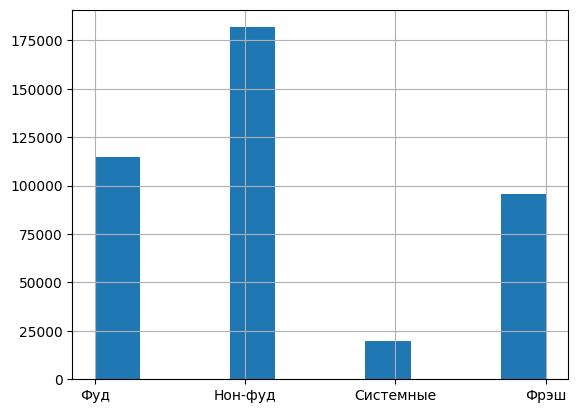

In [18]:
items['div_name'].hist()

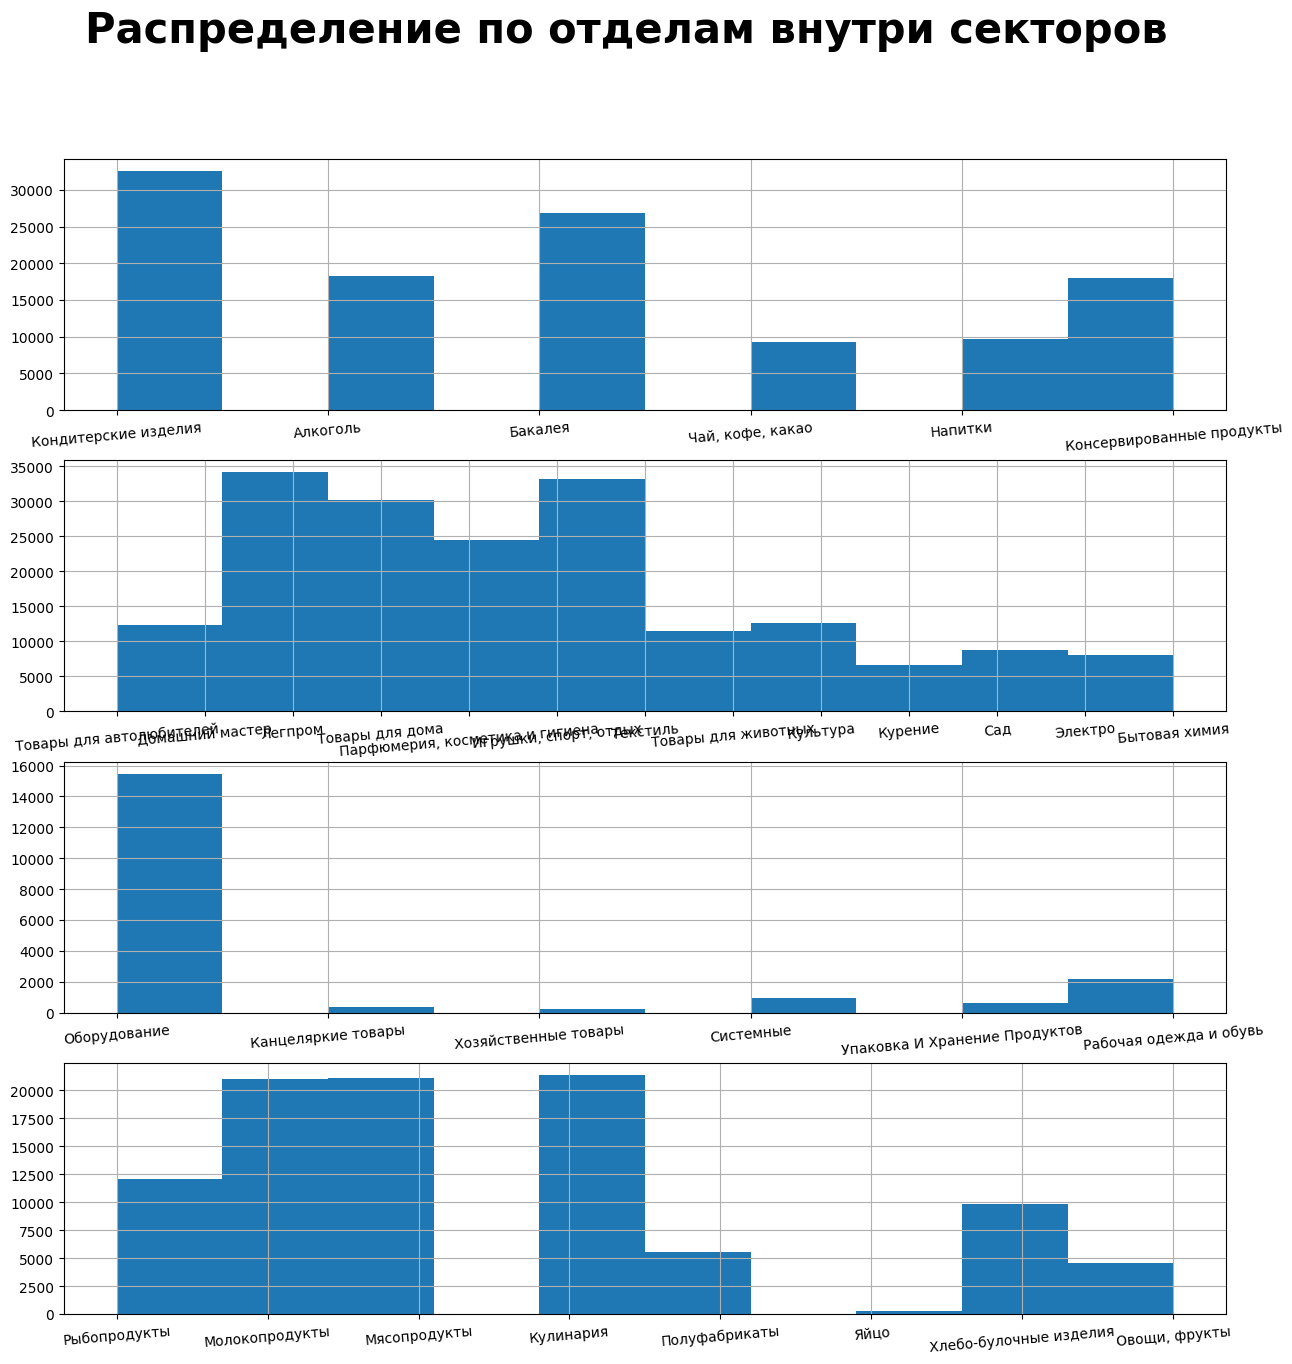

In [19]:
fig, axes = plt.subplots(4, 1, figsize = (15,15))
fig.suptitle('Распределение по отделам внутри секторов', fontsize = 30, fontweight='bold')
j=0
for i in items['division'].unique():
    items.query('division==@i')['group_name'].hist(ax=axes[j],xrot=5)
    j += 1



Определим список подгрупп с количеством элементов вхождения меньше 20, чтобы также исключить их из обучающей выборки

In [20]:
items.groupby(by='subclass')[['item_desc']].count().query('item_desc < 10')

item_desc
subclass           
316               6
332               5
943               4
1061              2
1064              2
...             ...
9926              2
9941              3
9942              2
9945              6
9952              4

[502 rows x 1 columns]

In [21]:
small_freq_subs = items.groupby(by='subclass')[['item_desc']].count().query('item_desc < 10').index.to_list()

In [22]:
items = items.query('~subclass.isin(@small_freq_subs)')

In [23]:
items.reset_index(drop=True, inplace=True)

Напишем функцию очистки и лемматизации текста.

In [24]:
def lemmatize_batch(text):
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    
    lemmatized = m.lemmatize(merged_text)
    
    for i in range(0, len(lemmatized)):
        if lemmatized[i] != '|' and i != len(lemmatized)-1:
            doc.append(lemmatized[i])
        else:
            res.append(doc)
            doc = []

    return res

In [25]:
def clean_and_lemmatize(texts):
    corpus = texts.copy()
    corpus = corpus.apply(lambda x: " ".join(re.sub(r'[^а-яА-ЯёЁ]', ' ', x).split()))
    corpus[corpus==''] = 'не определено'
    batch_size = 10000
    text_batch = [corpus[i: i + batch_size] for i in range(0, len(corpus), batch_size)]
    processed_texts = Parallel(n_jobs=-1)(delayed(lemmatize_batch)(t) for t in text_batch)
    res = [''.join(j) for i in processed_texts for j in i]
    return pd.DataFrame(res)

In [26]:
transformer = ColumnTransformer(
                    [   ('pass', 'passthrough', ['item']),
                        ('desc_vectorize', Pipeline([
                                            ('clean and lemmatize', FunctionTransformer(clean_and_lemmatize))#,
                                            #('vectorize', TfidfVectorizer(stop_words=stop_words))
                        ]),'item_desc')
                    ],
                    remainder='passthrough')

In [27]:
num_cols = items.select_dtypes('int64').columns.to_list()

In [28]:
items_transformed = pd.DataFrame(transformer.fit_transform(items),
                                       index=items.index,
                                       columns=items.columns)

In [29]:
items_transformed[num_cols] = items_transformed[num_cols].astype('int64')

Мы провели первичную подготовку нашего датасета, теперь перейдем к подготовке самих данных.
Т.к. данных очень много, то мы будем пробовать подбирать оптимальную модель по кускам, для этого зададим новую переменную, в которую будем передавать выбранную часть датафрейма.

In [30]:
classifier_step = ['division']

In [31]:
#items_train = items.query('group_name.isin(["Молокопродукты"])')
#items_train = items.copy()
items_rest, items_train = train_test_split(items_transformed, test_size=0.25, random_state=RANDOM_STATE, 
                                              stratify=items['division'])
classifier_step.append('item_desc')
items_train = items_train.set_index('item')[classifier_step]
#alco_cond = items.query('DIV_NAME.isin(["Фуд"])')
#alco_cond = items.copy()

In [32]:
print(f'Количество классов для попытки обучения {len(items_train[classifier_step[0]].unique())}')

Количество классов для попытки обучения 4


Разделим выборки на тренировочную и тестовую.

In [33]:
X_train, X_test, y_train, y_test = \
    train_test_split(items_train[['item_desc']], items_train[classifier_step[0]], \
                     test_size=0.25, random_state=RANDOM_STATE)

In [34]:
estimators = {'SCV': {'estimator': SVC(random_state=RANDOM_STATE),
                       'params': {'clf__C': np.arange(0.001, 10, 0.5),
                                  'clf__max_iter': range(0,10000,200),
                                  'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
             }}

Подбираем модель для предсказания сектора на тренировочной выборке.

In [35]:
estimators = {
              'KNeighborsClassifier': {'estimator': KNeighborsClassifier(),
                                'params':{'clf__n_neighbors':  [5, 10, 15],
                                          'clf__weights': ['uniform', 'distance'],
                                          'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                          'clf__leaf_size': [15, 30, 45, 60]}
                               }}

In [36]:
estimators = {'LSCV': {'estimator': LinearSVC(random_state=RANDOM_STATE,dual=False),
                       'params': {'clf__C': np.arange(0.001, 10, 0.5),
                                  'clf__max_iter': range(0,20000,1000)}},
              #'LR': {'estimator': LogisticRegression(n_jobs=-1),
              #       'params': {'clf__C':np.arange(0.001, 10, 0.5),
              #                  'clf__multi_class': ['ovr', 'multinomial'],
              #                  'clf__max_iter': range(0,20000,1000)}},
              'SGDClassifier': {'estimator': SGDClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                                'params':{'clf__alpha':  np.arange(0.001, 10, 0.5),
                                          'clf__loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                                          'clf__max_iter': range(1,10000,200),
                                          'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                                          'clf__eta0': np.arange(0.001, 10, 0.5),
                                          'clf__power_t': np.arange(-10, 10, 0.5)}},
              'MultinomialNB': {'estimator': MultinomialNB(),
                                'params':{'clf__alpha':  np.arange(0.001, 10, 0.5),
                                          'clf__force_alpha': [True, False],
                                          'clf__fit_prior': [True, False]}},
             }

In [37]:
best_f1 = 0
best_params = {}
best_estimator = None
for model_name, est in estimators.items():
    estimator = est['estimator']
    params = est['params']
    pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words=stop_words)),  
    ('clf', estimator)])
    grid_search = RandomizedSearchCV(pipe, params, scoring='f1_weighted', cv=3, random_state=RANDOM_STATE, n_jobs=-1,error_score='raise')
    grid_search.fit(X_train['item_desc'],y_train)
    f1 = grid_search.best_score_
    cv_params = grid_search.best_params_
    print(f'F1 модели {model_name} с лучшими параметрами:', f1)
    print(f'Лучшие параметры модели {model_name}:', cv_params) 
    if best_f1 < f1:
        best_f1 = f1
        best_estimator = grid_search.best_estimator_
        best_params = cv_params
print('-' * 120)
print(f'Наилучшая метрика F1 {best_f1} достигнута с помощью модели {best_estimator}')
print('-' * 120)

F1 модели LSCV с лучшими параметрами: 0.9748082837539656
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9647772310955225
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9632133508010078
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая метрика F1 0.9748082837539656 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['только', 'тоже', 'можно', 'их',
                                             'потому', 'чуть', 'то', 'него',
                                             'нибудь', 'по', 'опять

Тестируем лучшую модель на тестовой выборке

In [38]:
print(classification_report(y_test, best_estimator.predict(X_test['item_desc'])))

              precision    recall  f1-score   support

           7       0.99      0.99      0.99     11229
           8       0.97      0.97      0.97      5999
           9       0.97      0.97      0.97      7152
          10       0.98      0.91      0.94      1238

    accuracy                           0.98     25618
   macro avg       0.98      0.96      0.97     25618
weighted avg       0.98      0.98      0.98     25618



Тестируем лучшую модель, обученную на части данных на полной выборке.

In [39]:
print(classification_report(items_transformed['division'], best_estimator.predict(items_transformed['item_desc'])))

              precision    recall  f1-score   support

           7       0.99      0.99      0.99    180009
           8       0.97      0.97      0.97     95668
           9       0.98      0.97      0.97    114478
          10       0.98      0.92      0.95     19732

    accuracy                           0.98    409887
   macro avg       0.98      0.97      0.97    409887
weighted avg       0.98      0.98      0.98    409887



Записываем лучший эстиматор в переменную division_est - модель для определения сектора.

In [40]:
division_est = best_estimator

Обучаем division_est на полной выборке.

In [41]:
division_est.fit(items_transformed['item_desc'], items_transformed['division'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['только', 'тоже', 'можно', 'их',
                                             'потому', 'чуть', 'то', 'него',
                                             'нибудь', 'по', 'опять', 'были',
                                             'после', 'всегда', 'более', 'моя',
                                             'над', 'ему', 'все', 'я', 'чтобы',
                                             'много', 'почти', 'ты', 'этого',
                                             'меня', 'про', 'между', 'тем',
                                             'была', ...])),
                ('clf', LinearSVC(C=1.501, dual=False, random_state=4))])

Смотрим на результат предсказаний сектора обученного на всей выборке.

In [42]:
print(classification_report(items_transformed['division'], division_est.predict(items_transformed['item_desc'])))

              precision    recall  f1-score   support

           7       1.00      1.00      1.00    180009
           8       0.98      0.99      0.98     95668
           9       0.99      0.99      0.99    114478
          10       0.99      0.95      0.97     19732

    accuracy                           0.99    409887
   macro avg       0.99      0.98      0.99    409887
weighted avg       0.99      0.99      0.99    409887



Записываем в датасет колонку с предсказанием сектора, дальше будем смотреть только правдивые предсказания.

In [43]:
items_transformed['division_pred'] = division_est.predict(items_transformed['item_desc'])

Для каждого сектора находим лучшую модель для предсказания отдела

In [44]:
group_est = {}

for i in list(items_transformed['division'].unique()):
    items_temp = items_transformed.query('division_pred==division and division==@i')\
                            [['item','item_desc','group_no']].set_index('item')
    X_train, X_test, y_train, y_test = \
    train_test_split(items_temp[['item_desc']], items_temp['group_no'], \
                     test_size=0.25, random_state=RANDOM_STATE, stratify=items_temp['group_no'])
    
    best_f1 = 0
    best_params = {}
    best_estimator = None
    for model_name, est in estimators.items():
        estimator = est['estimator']
        params = est['params']
        pipe = Pipeline([
        ('vectorize', TfidfVectorizer(stop_words=stop_words)),  
        ('clf', estimator)])
        grid_search = RandomizedSearchCV(pipe, params, scoring='f1_weighted', cv=3, random_state=RANDOM_STATE, n_jobs=-1,error_score='raise')
        grid_search.fit(X_train['item_desc'],y_train)
        f1 = grid_search.best_score_
        cv_params = grid_search.best_params_
        print(f'F1 модели {model_name} с лучшими параметрами:', f1)
        print(f'Лучшие параметры модели {model_name}:', cv_params) 
        if best_f1 < f1:
            best_f1 = f1
            best_estimator = grid_search.best_estimator_
            best_params = cv_params
    print('-' * 120)
    print(f'Наилучшая для сектора {i} метрика F1 {best_f1} достигнута с помощью модели {best_estimator}')
    print('-' * 120)
    print(classification_report(y_test, best_estimator.predict(X_test['item_desc'])))
    group_est[i] = best_estimator
    

F1 модели LSCV с лучшими параметрами: 0.983351688959664
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9759194230366982
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9641918475212069
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для сектора 9 метрика F1 0.983351688959664 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['только', 'тоже', 'можно', 'их',
                                             'потому', 'чуть', 'то', 'него',
                                             'нибудь', 

Обучаем подобранные модели на полной выборке.

In [45]:
for i in list(items_transformed['division'].unique()):
    group_est[i].fit(items_transformed.query('division_pred==division and division==@i')['item_desc'], items_transformed.query('division_pred==division and division==@i')['group_no'])
    print(classification_report(items_transformed.query('division_pred==division and division==@i')['group_no'], group_est[i].predict(items_transformed.query('division_pred==division and division==@i')['item_desc'])))

              precision    recall  f1-score   support

          54       0.99      0.99      0.99     26292
          55       0.99      1.00      0.99     17538
          56       0.99      0.99      0.99      9633
          57       1.00      1.00      1.00     32139
          58       1.00      1.00      1.00     18208
          64       1.00      1.00      1.00      9296

    accuracy                           0.99    113106
   macro avg       0.99      1.00      0.99    113106
weighted avg       0.99      0.99      0.99    113106

              precision    recall  f1-score   support

          33       1.00      1.00      1.00      5122
          34       0.99      0.99      0.99      4856
          35       0.99      0.98      0.98     12449
          36       1.00      1.00      1.00      6606
          37       1.00      0.99      1.00     33911
          38       1.00      1.00      1.00     24337
          39       0.99      0.99      0.99      5347
          40       0.99 

Записываем в датафрейм items_transformed колонку с предсказаниями отдела.

In [46]:
n = 0
for i in list(items_transformed['division'].unique()):
    group_est[i].fit(items_transformed.query('division_pred==division and division==@i')['item_desc'], items_transformed.query('division_pred==division and division==@i')['group_no'])
    if n == 0:
        group_pred = pd.DataFrame(group_est[i].predict(items_transformed.query('division_pred==division and division==@i')['item_desc']),
                                  index = items_transformed.query('division_pred==division and division==@i')['item'], columns = ['group_no_pred'])
    else:
        group_pred = pd.concat([group_pred, pd.DataFrame(group_est[i].predict(items_transformed.query('division_pred==division and division==@i ')['item_desc']),
                                  index = items_transformed.query('division_pred==division and division==@i')['item'], columns = ['group_no_pred'])])
    n += 1

In [47]:
items_transformed = items_transformed.merge(group_pred, how='left', right_on='item', left_on='item')
items_transformed['group_no_pred'] = items_transformed['group_no_pred'].fillna(-1)
items_transformed['group_no_pred'] = items_transformed['group_no_pred'].astype('int64')

Внутри каждого отдела подбираем модели для предсказания направления.
Определяем эстиматоры для перебора

In [48]:
estimators_dept = {'LSCV': {'estimator': LinearSVC(random_state=RANDOM_STATE,dual=False),
                       'params': {'clf__C': np.arange(0.001, 10, 0.5),
                                  'clf__max_iter': range(0,20000,1000)}},
              #'LR': {'estimator': LogisticRegression(n_jobs=-1),
              #       'params': {'clf__C':np.arange(0.001, 10, 0.5),
              #                  'clf__multi_class': ['ovr', 'multinomial'],
              #                  'clf__max_iter': range(0,20000,1000)}},
              'SGDClassifier': {'estimator': SGDClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                                'params':{'clf__alpha':  np.arange(0.001, 10, 0.5),
                                          'clf__loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                                          'clf__max_iter': range(1,10000,200),
                                          'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                                          'clf__eta0': np.arange(0.001, 10, 0.5),
                                          'clf__power_t': np.arange(-10, 10, 0.5)}},
              'MultinomialNB': {'estimator': MultinomialNB(),
                                'params':{'clf__alpha':  np.arange(0.001, 10, 0.5),
                                          'clf__force_alpha': [True, False],
                                          'clf__fit_prior': [True, False]}},
             }

Определяем список отделов, которым соответствует всего один депт

In [49]:
single_dept = items.groupby(by='group_no')['dept'].nunique()\
                [items.groupby(by='group_no')['dept'].nunique() ==1].index.to_list()

In [50]:
dept_est = {}

for i in list(items_transformed.query('~group_no.isin(@single_dept)')['group_no'].unique()):
    items_temp = items_transformed.query('group_no_pred==group_no and group_no==@i')\
                            [['item','item_desc','dept']].set_index('item')
    X_train, X_test, y_train, y_test = \
    train_test_split(items_temp[['item_desc']], items_temp['dept'], \
                     test_size=0.25, random_state=RANDOM_STATE, stratify=items_temp['dept'])
    
    best_f1 = 0
    best_params = {}
    best_estimator = None
    for model_name, est in estimators_dept.items():
        estimator = est['estimator']
        params = est['params']
        pipe = Pipeline([
        ('vectorize', TfidfVectorizer(stop_words=stop_words)),  
        ('clf', estimator)])
        grid_search = RandomizedSearchCV(pipe, params, scoring='f1_weighted', cv=3, random_state=RANDOM_STATE, n_jobs=-1,error_score='raise')
        grid_search.fit(X_train['item_desc'],y_train)
        f1 = grid_search.best_score_
        cv_params = grid_search.best_params_
        print(f'F1 модели {model_name} с лучшими параметрами:', f1)
        print(f'Лучшие параметры модели {model_name}:', cv_params) 
        if best_f1 < f1:
            best_f1 = f1
            best_estimator = grid_search.best_estimator_
            best_params = cv_params
    print('-' * 120)
    print(f'Наилучшая для отдела {i} метрика F1 {best_f1} достигнута с помощью модели {best_estimator}')
    print('-' * 120)
    print(classification_report(y_test, best_estimator.predict(X_test['item_desc'])))
    dept_est[i] = best_estimator
    

F1 модели LSCV с лучшими параметрами: 0.9923794406101015
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9877087448517828
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9793426180121235
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 57 метрика F1 0.9923794406101015 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['только', 'тоже', 'можно', 'их',
                                             'потому', 'чуть', 'то', 'него',
                                             'нибудь'

F1 модели MultinomialNB с лучшими параметрами: 0.904163026044757
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 46 метрика F1 0.9527966771581914 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501, d

F1 модели LSCV с лучшими параметрами: 0.9548300663150643
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9476205032455476
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9307683232918039
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 45 метрика F1 0.9548300663150643 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели LSCV с лучшими параметрами: 0.9709525800949299
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9567352888231091
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9524439235865714
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 33 метрика F1 0.9709525800949299 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели MultinomialNB с лучшими параметрами: 0.8949417730590543
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 59 метрика F1 0.9079640447457824 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501, 

Добавляем в список моделей модели с одиночным выбором депта с помощью DummyClassifier.

In [51]:
for i in single_dept:
    items_temp = items_transformed.query('group_no_pred==group_no and group_no==@i')\
                            [['item','item_desc','dept']].set_index('item')
    model = DummyClassifier(strategy='constant', constant=items_temp['dept'].unique()[0])
    model.fit(items_temp['item_desc'], items_temp['dept'])
    dept_est[i] = model

Обучаем подобранные модели на полной выборке.

In [52]:
for i in list(items_transformed['group_no'].unique()):
    dept_est[i].fit(items_transformed.query('group_no_pred==group_no and group_no==@i')['item_desc'], items_transformed.query('group_no_pred==group_no and group_no==@i')['dept'])
    print(classification_report(items_transformed.query('group_no_pred==group_no and group_no==@i')['dept'], dept_est[i].predict(items_transformed.query('group_no_pred==group_no and group_no==@i')['item_desc'])))

              precision    recall  f1-score   support

         362       1.00      1.00      1.00     11195
         363       1.00      1.00      1.00     20825

    accuracy                           1.00     32020
   macro avg       1.00      1.00      1.00     32020
weighted avg       1.00      1.00      1.00     32020

              precision    recall  f1-score   support

         285       1.00      1.00      1.00      7141

    accuracy                           1.00      7141
   macro avg       1.00      1.00      1.00      7141
weighted avg       1.00      1.00      1.00      7141

              precision    recall  f1-score   support

         240       1.00      1.00      1.00       340
         241       0.96      0.96      0.96       217
         242       0.99      0.99      0.99       398
         243       1.00      0.99      0.99       208
         244       0.99      0.99      0.99      1367
         246       0.97      0.97      0.97       544
         247       1.

Записываем в датафрейм items_transformed колонку с предсказаниями депта.

In [53]:
n = 0
for i in list(items_transformed['group_no'].unique()):
    dept_est[i].fit(items_transformed.query('group_no_pred==group_no and group_no==@i')['item_desc'], items_transformed.query('group_no_pred==group_no and group_no==@i')['dept'])
    if n == 0:
        dept_pred = pd.DataFrame(dept_est[i].predict(items_transformed.query('group_no_pred==group_no and group_no==@i')['item_desc']),
                                  index = items_transformed.query('group_no_pred==group_no and group_no==@i')['item'], columns = ['dept_no_pred'])
    else:
        dept_pred = pd.concat([dept_pred, pd.DataFrame(dept_est[i].predict(items_transformed.query('group_no_pred==group_no and group_no==@i ')['item_desc']),
                                  index = items_transformed.query('group_no_pred==group_no and group_no==@i')['item'], columns = ['dept_no_pred'])])
    n += 1

In [54]:
items_transformed = items_transformed.merge(dept_pred, how='left', right_on='item', left_on='item')
items_transformed['dept_no_pred'] = items_transformed['dept_no_pred'].fillna(-1)
items_transformed['dept_no_pred'] = items_transformed['dept_no_pred'].astype('int64')

Для исключения передачи в модель для обучения классов, в которых до 3х наблюдений, определим такие классы и выкинем их из выборки для обучения.

In [55]:
small_freq_class = items_transformed.query('dept==dept_no_pred').\
                        groupby(by='class')[['item_desc']].count().query('item_desc < 4').index.to_list()

In [56]:
items_transformed_class = items_transformed[~items_transformed['class'].isin(small_freq_class)]

Определяем список направлений, которым соответствует всего одна группа

In [57]:
single_class = items_transformed_class.query('dept==dept_no_pred').groupby(by='dept')['class'].nunique()\
                [items_transformed_class.query('dept==dept_no_pred').groupby(by='dept')['class'].nunique() ==1].index.to_list()

In [58]:
class_est = {}

for i in list(items_transformed_class.query('~dept.isin(@single_class)')['dept'].unique()):
    items_temp = items_transformed_class.query('dept_no_pred==dept and dept==@i')\
                            [['item','item_desc','class']].set_index('item')
    X_train, X_test, y_train, y_test = \
    train_test_split(items_temp[['item_desc']], items_temp['class'], \
                     test_size=0.25, random_state=RANDOM_STATE, stratify=items_temp['class'])
    
    best_f1 = 0
    best_params = {}
    best_estimator = None
    for model_name, est in estimators_dept.items():
        estimator = est['estimator']
        params = est['params']
        pipe = Pipeline([
        ('vectorize', TfidfVectorizer(stop_words=stop_words)),  
        ('clf', estimator)])
        grid_search = RandomizedSearchCV(pipe, params, scoring='f1_weighted', cv=3, random_state=RANDOM_STATE, n_jobs=-1,error_score='raise')
        grid_search.fit(X_train['item_desc'],y_train)
        f1 = grid_search.best_score_
        cv_params = grid_search.best_params_
        print(f'F1 модели {model_name} с лучшими параметрами:', f1)
        print(f'Лучшие параметры модели {model_name}:', cv_params) 
        if best_f1 < f1:
            best_f1 = f1
            best_estimator = grid_search.best_estimator_
            best_params = cv_params
    print('-' * 120)
    print(f'Наилучшая для отдела {i} метрика F1 {best_f1} достигнута с помощью модели {best_estimator}')
    print('-' * 120)
    print(classification_report(y_test, best_estimator.predict(X_test['item_desc'])))
    class_est[i] = best_estimator

F1 модели LSCV с лучшими параметрами: 0.9034336689940874
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8815996498367972
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8411430832169974
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 363 метрика F1 0.9034336689940874 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['только', 'тоже', 'можно', 'их',
                                             'потому', 'чуть', 'то', 'него',
                                             'нибуд

F1 модели LSCV с лучшими параметрами: 0.9530363940295148
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9159253065942806
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9389430411762478
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 301 метрика F1 0.9530363940295148 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему',

F1 модели SGDClassifier с лучшими параметрами: 0.8776611809640134
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8397633704152726
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 293 метрика F1 0.9074906514033868 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                        

F1 модели LSCV с лучшими параметрами: 0.9855044408107311
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9808758609444529
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9742236872522758
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 365 метрика F1 0.9855044408107311 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.9887472157460299
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.974710192730995
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9589042450695028
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 8.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 280 метрика F1 0.9887472157460299 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где'

F1 модели LSCV с лучшими параметрами: 0.9800884170542297
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9561655914454493
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9675745601250902
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 286 метрика F1 0.9800884170542297 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.9962696657332387
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9729246250692406
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9714979679424625
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 279 метрика F1 0.9962696657332387 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.9707052464450002
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9503004917226701
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.931335756424745
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 266 метрика F1 0.9707052464450002 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему',

F1 модели LSCV с лучшими параметрами: 0.9367819361117781
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9095065174081287
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8860404113006436
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 8.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 344 метрика F1 0.9367819361117781 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели MultinomialNB с лучшими параметрами: 0.7791667578487927
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 373 метрика F1 0.8226490289896087 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501,

F1 модели MultinomialNB с лучшими параметрами: 0.9520066176617376
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 307 метрика F1 0.9768087311284713 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 L

F1 модели SGDClassifier с лучшими параметрами: 0.9377055853759128
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9259201651663984
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': True, 'clf__alpha': 2.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 357 метрика F1 0.9557030491587266 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                          

F1 модели LSCV с лучшими параметрами: 0.9493343908743598
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9332583762177755
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9313468464457738
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 240 метрика F1 0.9493343908743598 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где'

F1 модели MultinomialNB с лучшими параметрами: 0.9593640263618264
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 360 метрика F1 0.978651207183589 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 Li

F1 модели MultinomialNB с лучшими параметрами: 0.8946174575671391
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 313 метрика F1 0.9285839692665018 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501,

F1 модели LSCV с лучшими параметрами: 0.9634521575727035
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9431234311714999
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9137433883828648
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 259 метрика F1 0.9634521575727035 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.9480398767963849
Лучшие параметры модели LSCV: {'clf__max_iter': 7000, 'clf__C': 9.001}
F1 модели SGDClassifier с лучшими параметрами: 0.9228589849906058
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8971807985717319
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 329 метрика F1 0.9480398767963849 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели MultinomialNB с лучшими параметрами: 0.9719276832593636
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': True, 'clf__alpha': 9.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 346 метрика F1 0.983303152667618 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501, du

F1 модели LSCV с лучшими параметрами: 0.9936703092025082
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9908469044074528
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9905019500482917
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 256 метрика F1 0.9936703092025082 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему',

F1 модели MultinomialNB с лучшими параметрами: 0.909720836928547
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 336 метрика F1 0.9581904581064326 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501, 

F1 модели LSCV с лучшими параметрами: 0.985403288666063
Лучшие параметры модели LSCV: {'clf__max_iter': 14000, 'clf__C': 6.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9355899637570246
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.959958797960037
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 318 метрика F1 0.985403288666063 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели LSCV с лучшими параметрами: 0.9351203522965061
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9071339266664785
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8819471999815734
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 392 метрика F1 0.9351203522965061 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели MultinomialNB с лучшими параметрами: 0.9276166818284718
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 396 метрика F1 0.9628655629659356 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501,

F1 модели LSCV с лучшими параметрами: 1.0
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9964144367653139
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 1.0
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 366 метрика F1 1.0 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                 

F1 модели LSCV с лучшими параметрами: 0.9646030043299186
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9512740054814035
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9520418474021581
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 316 метрика F1 0.9646030043299186 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'гд

F1 модели SGDClassifier с лучшими параметрами: 0.7671264379445871
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7786958832557698
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 379 метрика F1 0.8055917515982808 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                        

F1 модели MultinomialNB с лучшими параметрами: 0.9962667581396678
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 274 метрика F1 0.9962667581396678 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 Li

F1 модели LSCV с лучшими параметрами: 0.9791066076780363
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9717171717171716
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9791066076780363
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 305 метрика F1 0.9791066076780363 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

In [59]:
for i in single_class:
    items_temp = items_transformed_class.query('dept_no_pred==dept and dept==@i')\
                            [['item','item_desc','class']].set_index('item')
    model = DummyClassifier(strategy='constant', constant=items_temp['class'].unique()[0])
    model.fit(items_temp['item_desc'], items_temp['class'])
    class_est[i] = model

In [60]:
for i in list(items_transformed_class['dept'].unique()):
    class_est[i].fit(items_transformed_class.query('dept_no_pred==dept and dept==@i')['item_desc'], items_transformed_class.query('dept_no_pred==dept and dept==@i')['class'])
    print(classification_report(items_transformed_class.query('dept_no_pred==dept and dept==@i')['class'], class_est[i].predict(items_transformed_class.query('dept_no_pred==dept and dept==@i')['item_desc'])))

              precision    recall  f1-score   support

        2093       1.00      0.93      0.97        45
        2094       0.95      0.95      0.95       784
        2095       1.00      0.99      0.99       743
        2096       0.96      0.94      0.95      1206
        2097       0.97      0.99      0.98       569
        2098       0.98      0.95      0.97        62
        2100       0.95      0.96      0.95      1272
        2101       0.97      0.97      0.97      2117
        2102       0.97      0.98      0.97      1703
        2103       0.96      0.96      0.96      3871
        2106       0.99      0.97      0.98      1963
        2107       0.99      0.99      0.99      2219
        2108       1.00      1.00      1.00       141
        2109       0.98      0.99      0.99      2612
        2111       0.96      0.99      0.97       235
        2705       0.99      0.98      0.98      1249

    accuracy                           0.97     20791
   macro avg       0.98   

              precision    recall  f1-score   support

        2022       0.96      0.97      0.97      2364
        2023       0.98      0.98      0.98      4270

    accuracy                           0.97      6634
   macro avg       0.97      0.97      0.97      6634
weighted avg       0.98      0.97      0.98      6634

              precision    recall  f1-score   support

        1560       0.99      1.00      1.00      1329
        1561       1.00      0.99      1.00       275
        1562       1.00      1.00      1.00       183
        1563       1.00      1.00      1.00      2461

    accuracy                           1.00      4248
   macro avg       1.00      1.00      1.00      4248
weighted avg       1.00      1.00      1.00      4248

              precision    recall  f1-score   support

        1753       0.92      0.94      0.93       419
        1754       0.99      1.00      1.00       188
        1755       0.94      0.96      0.95        78
        1756       0.

              precision    recall  f1-score   support

        1491       1.00      1.00      1.00        16
        1492       0.99      1.00      0.99       179
        1493       1.00      0.85      0.92        13

    accuracy                           0.99       208
   macro avg       1.00      0.95      0.97       208
weighted avg       0.99      0.99      0.99       208

              precision    recall  f1-score   support

        1902       1.00      0.99      0.99       270
        1903       0.99      0.99      0.99       313
        1905       0.98      1.00      0.99        53
        1906       1.00      1.00      1.00       242

    accuracy                           1.00       878
   macro avg       0.99      1.00      0.99       878
weighted avg       1.00      1.00      1.00       878

              precision    recall  f1-score   support

        1850       1.00      1.00      1.00       211
        1851       1.00      1.00      1.00        36
        1852       1.

              precision    recall  f1-score   support

        2002       0.97      0.97      0.97      1661
        2003       0.98      0.99      0.98      5288
        2004       0.98      0.83      0.90       108
        2005       0.99      0.99      0.99      3724
        2473       0.99      0.95      0.97       161

    accuracy                           0.98     10942
   macro avg       0.98      0.95      0.96     10942
weighted avg       0.98      0.98      0.98     10942

              precision    recall  f1-score   support

        2521       1.00      1.00      1.00      1315
        2522       0.99      0.99      0.99       241
        2523       0.99      1.00      1.00       159
        2524       1.00      0.95      0.97        19

    accuracy                           1.00      1734
   macro avg       1.00      0.98      0.99      1734
weighted avg       1.00      1.00      1.00      1734

              precision    recall  f1-score   support

        1971       1.

              precision    recall  f1-score   support

        2006       1.00      0.99      1.00       463
        2007       0.99      1.00      0.99      2522
        2008       0.98      0.94      0.96       494
        2009       1.00      1.00      1.00       161
        2010       1.00      1.00      1.00      1511
        2703       0.93      0.97      0.95       140

    accuracy                           0.99      5291
   macro avg       0.98      0.98      0.98      5291
weighted avg       0.99      0.99      0.99      5291

              precision    recall  f1-score   support

        1918       1.00      1.00      1.00       567
        1920       1.00      1.00      1.00        18
        1921       1.00      1.00      1.00       351
        1922       1.00      1.00      1.00        68
        1924       1.00      1.00      1.00        17
        1928       1.00      1.00      1.00       138
        1929       1.00      1.00      1.00        86
        1930       1.00 

              precision    recall  f1-score   support

        2147       1.00      1.00      1.00        91

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

              precision    recall  f1-score   support

        1502       1.00      1.00      1.00        23
        1503       1.00      1.00      1.00       183

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206

              precision    recall  f1-score   support

        1662       1.00      1.00      1.00       118
        1663       1.00      1.00      1.00       136

    accuracy                           1.00       254
   macro avg       1.00      1.00      1.00       254
weighted avg       1.00      1.00      1.00       254

              precision    recall  f1-score   support

        1665      

              precision    recall  f1-score   support

        1533       1.00      1.00      1.00       105

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

              precision    recall  f1-score   support

        1553       1.00      1.00      1.00        69

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

              precision    recall  f1-score   support

        1974       1.00      1.00      1.00        44

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

              precision    recall  f1-score   support

        2134       1.00      1.00      1.00      2182

    accuracy                           1.00      2182
   macro avg     

In [61]:
n = 0
for i in list(items_transformed_class['dept'].unique()):
    class_est[i].fit(items_transformed_class.query('dept_no_pred==dept and dept==@i')['item_desc'], items_transformed_class.query('dept_no_pred==dept and dept==@i')['class'])
    if n == 0:
        class_pred = pd.DataFrame(class_est[i].predict(items_transformed_class.query('dept_no_pred==dept and dept==@i')['item_desc']),
                                  index = items_transformed_class.query('dept_no_pred==dept and dept==@i')['item'], columns = ['class_pred'])
    else:
        class_pred = pd.concat([class_pred, pd.DataFrame(class_est[i].predict(items_transformed_class.query('dept_no_pred==dept and dept==@i ')['item_desc']),
                                  index = items_transformed_class.query('dept_no_pred==dept and dept==@i')['item'], columns = ['class_pred'])])
    n += 1

In [62]:
items_transformed = items_transformed.merge(class_pred, how='left', right_on='item', left_on='item')
items_transformed['class_pred'] = items_transformed['class_pred'].fillna(-1)
items_transformed['class_pred'] = items_transformed['class_pred'].astype('int64')

In [63]:
small_freq_subclass = items_transformed[items_transformed['class']==items_transformed['class_pred']].\
                        groupby(by='subclass')[['item_desc']].count().query('item_desc < 4').index.to_list()

In [195]:
items_transformed_subclass = items_transformed[~items_transformed['subclass'].isin(small_freq_subclass)]

In [65]:
#items_transformed_subclass = items_transformed_subclass[items_transformed_subclass['class']!=2679]

In [196]:
items_transformed_subclass = items_transformed_subclass[items_transformed_subclass['class']!=1800]

In [197]:
single_subclass = items_transformed_subclass[items_transformed_subclass['class']==items_transformed_subclass['class_pred']].groupby(by='class')['subclass'].nunique()\
                [items_transformed_subclass[items_transformed_subclass['class']==items_transformed_subclass['class_pred']].groupby(by='class')['subclass'].nunique() ==1].index.to_list()

In [198]:
subclass_est = {}

for i in list(items_transformed_subclass[~items_transformed_subclass['class'].isin(single_subclass)]['class'].unique()):
    items_temp = items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)][['item','item_desc','subclass']].set_index('item')

    X_train, X_test, y_train, y_test = \
    train_test_split(items_temp[['item_desc']], items_temp['subclass'], \
                     test_size=0.25, random_state=RANDOM_STATE, stratify=items_temp['subclass'])
    
    best_f1 = 0
    best_params = {}
    best_estimator = None
    for model_name, est in estimators_dept.items():
        estimator = est['estimator']
        params = est['params']
        pipe = Pipeline([
        ('vectorize', TfidfVectorizer(stop_words=stop_words)),  
        ('clf', estimator)])
        grid_search = RandomizedSearchCV(pipe, params, scoring='f1_weighted', cv=3, random_state=RANDOM_STATE, n_jobs=-1,error_score='raise')
        grid_search.fit(X_train['item_desc'],y_train)
        f1 = grid_search.best_score_
        cv_params = grid_search.best_params_
        print(f'F1 модели {model_name} с лучшими параметрами:', f1)
        print(f'Лучшие параметры модели {model_name}:', cv_params) 
        if best_f1 < f1:
            best_f1 = f1
            best_estimator = grid_search.best_estimator_
            best_params = cv_params
    print('-' * 120)
    print(f'Наилучшая для отдела {i} метрика F1 {best_f1} достигнута с помощью модели {best_estimator}')
    print('-' * 120)
    print(classification_report(y_test, best_estimator.predict(X_test['item_desc'])))
    subclass_est[i] = best_estimator

F1 модели LSCV с лучшими параметрами: 0.8219289750426281
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7927887851363214
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7493279374501122
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2705 метрика F1 0.8219289750426281 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['только', 'тоже', 'можно', 'их',
                                             'потому', 'чуть', 'то', 'него',
                                             'нибу

F1 модели LSCV с лучшими параметрами: 0.9743589743589745
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 1.0
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 1.0
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1532 метрика F1 1.0 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                

F1 модели LSCV с лучшими параметрами: 0.8466724161103024
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8209200024412396
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8092694651538589
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1769 метрика F1 0.8466724161103024 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели LSCV с лучшими параметрами: 0.6437449965057381
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.6236169274230443
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.5155028671516736
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2113 метрика F1 0.6437449965057381 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ем

F1 модели LSCV с лучшими параметрами: 0.6077745827674008
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.6261913654962221
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.6247793130319873
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 4.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1510 метрика F1 0.6261913654962221 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели LSCV с лучшими параметрами: 0.945852834786673
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9399499350283994
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9135746876987798
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1599 метрика F1 0.945852834786673 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели LSCV с лучшими параметрами: 0.9606789409420989
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9408996751026218
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9404341845518317
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1737 метрика F1 0.9606789409420989 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели LSCV с лучшими параметрами: 0.9688475532692448
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9601833213735625
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9567336393633693
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 4.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1950 метрика F1 0.9688475532692448 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели MultinomialNB с лучшими параметрами: 0.6544067624672415
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2116 метрика F1 0.7650487452549356 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.8325630713450658
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7913069864180985
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7390509177486577
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1632 метрика F1 0.8325630713450658 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'г

F1 модели MultinomialNB с лучшими параметрами: 0.8293935402751021
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2021 метрика F1 0.8459532124727972 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.9908793896646123
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9479313837724445
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8447719920991504
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1843 метрика F1 0.9908793896646123 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели SGDClassifier с лучшими параметрами: 0.8146439657297974
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8153986862262905
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2023 метрика F1 0.8446905311554497 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                       

F1 модели LSCV с лучшими параметрами: 0.9907022704160205
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9804262702440042
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9758165538728846
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1673 метрика F1 0.9907022704160205 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели SGDClassifier с лучшими параметрами: 0.641393790619797
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.6083049517422042
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2018 метрика F1 0.641393790619797 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                

F1 модели LSCV с лучшими параметрами: 0.4002591112161336
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.3853701612487248
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.4512178563954376
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1830 метрика F1 0.4512178563954376 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'гд

F1 модели LSCV с лучшими параметрами: 0.9434039604080661
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9211408415347782
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9093890628532719
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2001 метрика F1 0.9434039604080661 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели MultinomialNB с лучшими параметрами: 0.922568717462877
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1751 метрика F1 0.9339631964580764 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 Li

F1 модели MultinomialNB с лучшими параметрами: 0.9548661504217059
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1492 метрика F1 0.9704451926674148 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 L

F1 модели MultinomialNB с лучшими параметрами: 0.6847407734042313
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1827 метрика F1 0.7948904625299605 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.9080527916558784
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8867041281375969
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8848043452888801
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1880 метрика F1 0.9080527916558784 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели SGDClassifier с лучшими параметрами: 0.7640745285910494
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7193087398827966
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2103 метрика F1 0.8107870901561164 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                       

F1 модели MultinomialNB с лучшими параметрами: 0.9113954497844313
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1577 метрика F1 0.9877609269388179 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 L

F1 модели SGDClassifier с лучшими параметрами: 0.8940766302070832
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8491843646524292
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2005 метрика F1 0.9126420052857762 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                       

F1 модели LSCV с лучшими параметрами: 0.7410310763840724
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7002248973106674
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.657843456404451
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1782 метрика F1 0.7410310763840724 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели SGDClassifier с лучшими параметрами: 0.8064349361784172
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8312314302255143
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1471 метрика F1 0.8846315454407486 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                       

F1 модели MultinomialNB с лучшими параметрами: 0.7495120053754741
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1468 метрика F1 0.8638525394689006 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели SGDClassifier с лучшими параметрами: 0.9134006454905469
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9141140317499877
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2096 метрика F1 0.9282843685867191 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                       

F1 модели LSCV с лучшими параметрами: 0.9319124848110071
Лучшие параметры модели LSCV: {'clf__max_iter': 7000, 'clf__C': 9.001}
F1 модели SGDClassifier с лучшими параметрами: 0.8981707973139591
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9000115017284899
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1749 метрика F1 0.9319124848110071 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'гд

F1 модели LSCV с лучшими параметрами: 0.8474274027117055
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8372910695002566
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7952062364083048
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1753 метрика F1 0.8474274027117055 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели MultinomialNB с лучшими параметрами: 0.9187984594498778
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1882 метрика F1 0.9507550751076396 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.9830549868262587
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9532071780032276
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8692053967965294
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1842 метрика F1 0.9830549868262587 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ем

              precision    recall  f1-score   support

        9390       0.60      0.75      0.67         4
        9391       0.62      1.00      0.77         5
        9392       0.80      0.44      0.57         9

    accuracy                           0.67        18
   macro avg       0.68      0.73      0.67        18
weighted avg       0.71      0.67      0.65        18

F1 модели LSCV с лучшими параметрами: 0.9668692002769114
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9488683776452863
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.945896541718303
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------

F1 модели LSCV с лучшими параметрами: 0.9056971095695712
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8801298401810422
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8653799594690529
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1711 метрика F1 0.9056971095695712 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

              precision    recall  f1-score   support

        9744       1.00      1.00      1.00         4
        9745       0.94      1.00      0.97        16
        9746       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.98      0.98        40
weighted avg       0.98      0.97      0.98        40

F1 модели LSCV с лучшими параметрами: 0.7939526639963552
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7674081379290792
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7459905138675275
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
-----------------------------------------------------------

F1 модели LSCV с лучшими параметрами: 0.9968886910942986
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9875347366739398
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.993802719448213
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': True, 'clf__alpha': 8.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1730 метрика F1 0.9968886910942986 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели SGDClassifier с лучшими параметрами: 0.8397604586573411
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8693412100766357
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': True, 'clf__alpha': 2.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1996 метрика F1 0.8754751880580501 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                         

F1 модели MultinomialNB с лучшими параметрами: 0.7526752294709435
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2022 метрика F1 0.7801173115337628 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.9199644591215296
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9004640529803859
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8922731991285263
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1955 метрика F1 0.9199644591215296 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели MultinomialNB с лучшими параметрами: 0.9184077318930028
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1542 метрика F1 0.9415276726806828 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.9714023112591703
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9374938846822829
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9496452122802063
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2012 метрика F1 0.9714023112591703 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.857209093063279
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8405839724768951
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7617973425852121
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2094 метрика F1 0.857209093063279 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели SGDClassifier с лучшими параметрами: 0.6873475935828877
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.663118654576455
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1961 метрика F1 0.7257483927209326 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                        

F1 модели LSCV с лучшими параметрами: 0.8470424779087985
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8174278311984077
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8115905843880672
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1605 метрика F1 0.8470424779087985 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели MultinomialNB с лучшими параметрами: 0.93583559017032
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1977 метрика F1 0.9830405438136016 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501, 

F1 модели LSCV с лучшими параметрами: 0.9582815083410469
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8746415959684252
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9325434354815508
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2506 метрика F1 0.9582815083410469 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели SGDClassifier с лучшими параметрами: 0.9128212688584206
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.948203842940685
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1535 метрика F1 0.948203842940685 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                               

              precision    recall  f1-score   support

        7563       1.00      0.75      0.86         4
        7565       1.00      1.00      1.00        12
        7566       0.90      1.00      0.95         9

    accuracy                           0.96        25
   macro avg       0.97      0.92      0.93        25
weighted avg       0.96      0.96      0.96        25

F1 модели LSCV с лучшими параметрами: 0.861198611846985
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8210326506156699
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8143803227980494
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------

F1 модели SGDClassifier с лучшими параметрами: 0.9133444586362511
Лучшие параметры модели SGDClassifier: {'clf__power_t': -3.0, 'clf__max_iter': 1, 'clf__loss': 'hinge', 'clf__learning_rate': 'optimal', 'clf__eta0': 8.501, 'clf__alpha': 2.501}
F1 модели MultinomialNB с лучшими параметрами: 0.9133444586362511
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2147 метрика F1 0.9133444586362511 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                 

F1 модели LSCV с лучшими параметрами: 0.9054813004790656
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8432386025925837
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8821979997180315
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1644 метрика F1 0.9054813004790656 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели MultinomialNB с лучшими параметрами: 0.8195841591244554
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2087 метрика F1 0.8610452610043776 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели MultinomialNB с лучшими параметрами: 0.6968367736514113
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1656 метрика F1 0.7911717402326258 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501

F1 модели LSCV с лучшими параметрами: 0.9941119882296352
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9786915846604427
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9941119882296352
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1465 метрика F1 0.9941119882296352 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели LSCV с лучшими параметрами: 0.9745754932649663
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9732534908222181
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9235208399473666
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1537 метрика F1 0.9745754932649663 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.8141791311544351
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.793280784935154
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7813570209971242
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1814 метрика F1 0.8141791311544351 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему',

F1 модели SGDClassifier с лучшими параметрами: 0.9855175688509021
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9865547365547366
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1743 метрика F1 0.9865547365547366 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                              

F1 модели LSCV с лучшими параметрами: 0.9814511739884875
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.977124183006536
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.977124183006536
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1582 метрика F1 0.9814511739884875 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели LSCV с лучшими параметрами: 0.9202654248931168
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8932378729723937
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8630628526779288
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2000 метрика F1 0.9202654248931168 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'гд

F1 модели SGDClassifier с лучшими параметрами: 0.8079668381897568
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8051761015412909
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1508 метрика F1 0.8651048896724101 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                        

F1 модели LSCV с лучшими параметрами: 0.9366010362548965
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9141006705117293
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8762752944977468
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1580 метрика F1 0.9366010362548965 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели MultinomialNB с лучшими параметрами: 0.819406903165167
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 4.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1655 метрика F1 0.9259349872967585 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501,

F1 модели LSCV с лучшими параметрами: 0.9448582281915615
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9560829959380683
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9577397910731243
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1604 метрика F1 0.9577397910731243 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели LSCV с лучшими параметрами: 0.9760711302064685
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9569364231835626
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.953331740723045
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1509 метрика F1 0.9760711302064685 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где'

F1 модели MultinomialNB с лучшими параметрами: 0.9628711345148254
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 4.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1739 метрика F1 0.9705779455509705 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 

F1 модели LSCV с лучшими параметрами: 0.9773024287792221
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9396752801605567
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9560593259458511
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 4.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1862 метрика F1 0.9773024287792221 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'гд

F1 модели MultinomialNB с лучшими параметрами: 0.8382226008094548
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1672 метрика F1 0.8874447146901036 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 

F1 модели LSCV с лучшими параметрами: 0.7791068580542264
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7353541464249268
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7696463380673908
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1755 метрика F1 0.7791068580542264 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ем

F1 модели MultinomialNB с лучшими параметрами: 0.9773519163763066
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2672 метрика F1 0.9773519163763066 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 L

F1 модели LSCV с лучшими параметрами: 0.9782235285086606
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9704869829522927
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9696375907985528
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1609 метрика F1 0.9782235285086606 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели LSCV с лучшими параметрами: 0.8938919626906278
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8780078143693082
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9019541745225649
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1487 метрика F1 0.9019541745225649 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели LSCV с лучшими параметрами: 0.8107824977242449
Лучшие параметры модели LSCV: {'clf__max_iter': 12000, 'clf__C': 7.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8034339035812739
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7306989043440838
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1778 метрика F1 0.8107824977242449 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели MultinomialNB с лучшими параметрами: 0.7834029036480401
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 8.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1979 метрика F1 0.856774800826083 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 L

F1 модели LSCV с лучшими параметрами: 0.6888888888888888
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.6888888888888888
Лучшие параметры модели SGDClassifier: {'clf__power_t': -3.0, 'clf__max_iter': 1, 'clf__loss': 'hinge', 'clf__learning_rate': 'optimal', 'clf__eta0': 8.501, 'clf__alpha': 2.501}
F1 модели MultinomialNB с лучшими параметрами: 0.7333333333333334
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1804 метрика F1 0.7333333333333334 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 

F1 модели LSCV с лучшими параметрами: 0.9977354150261853
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9932314968434514
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9965178384963543
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1608 метрика F1 0.9977354150261853 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели MultinomialNB с лучшими параметрами: 0.9523903079750419
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 8.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1668 метрика F1 0.9642753996427085 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 

F1 модели LSCV с лучшими параметрами: 0.9650716070070908
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9650716070070908
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9650716070070908
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1710 метрика F1 0.9650716070070908 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели LSCV с лучшими параметрами: 0.9661039991510264
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9707445524026909
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9578103244221664
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2483 метрика F1 0.9707445524026909 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему'

F1 модели MultinomialNB с лучшими параметрами: 0.9854814814814814
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1617 метрика F1 1.0 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 LinearSVC(C=4.50

F1 модели LSCV с лучшими параметрами: 0.7934129101232671
Лучшие параметры модели LSCV: {'clf__max_iter': 1000, 'clf__C': 1.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7438557814690888
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7452717686676701
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1786 метрика F1 0.7934129101232671 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему

F1 модели LSCV с лучшими параметрами: 0.7776651468916138
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7167185910761268
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7249196756628126
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1767 метрика F1 0.7776651468916138 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'гд

F1 модели MultinomialNB с лучшими параметрами: 0.9196210421750596
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1890 метрика F1 0.9626298145583085 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 

F1 модели SGDClassifier с лучшими параметрами: 0.9673237868810419
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.9625222889037701
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1563 метрика F1 0.9841819710567249 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                       

F1 модели MultinomialNB с лучшими параметрами: 0.7506187203749124
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 2486 метрика F1 0.8345174433409728 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf', LinearSVC(C=1.501,

F1 модели LSCV с лучшими параметрами: 0.7646882971125395
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.7509004183246607
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.7752987555808871
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1813 метрика F1 0.7752987555808871 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где

F1 модели LSCV с лучшими параметрами: 0.807748057884174
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8577636483886484
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.848239426607548
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1964 метрика F1 0.8577636483886484 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где',

F1 модели LSCV с лучшими параметрами: 0.942857142857143
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8857142857142858
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8857142857142858
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1534 метрика F1 0.942857142857143 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 

F1 модели LSCV с лучшими параметрами: 0.86930473659659
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.8197541592081056
Лучшие параметры модели SGDClassifier: {'clf__power_t': 5.5, 'clf__max_iter': 1801, 'clf__loss': 'huber', 'clf__learning_rate': 'constant', 'clf__eta0': 9.501, 'clf__alpha': 0.001}
F1 модели MultinomialNB с лучшими параметрами: 0.8544713033093841
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': True, 'clf__alpha': 0.501}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1757 метрика F1 0.86930473659659 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', '

F1 модели LSCV с лучшими параметрами: 0.9146931431141957
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 0.9072968616828266
Лучшие параметры модели SGDClassifier: {'clf__power_t': -3.0, 'clf__max_iter': 1, 'clf__loss': 'hinge', 'clf__learning_rate': 'optimal', 'clf__eta0': 8.501, 'clf__alpha': 2.501}
F1 модели MultinomialNB с лучшими параметрами: 0.9266237985536231
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 8.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1621 метрика F1 0.9266237985536231 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где',

F1 модели MultinomialNB с лучшими параметрами: 0.9534744815319723
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': False, 'clf__fit_prior': False, 'clf__alpha': 2.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1488 метрика F1 0.965315014894847 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                                             'она', 'нее', 'всегда', 'он',
                                             'для', 'куда', 'вот', 'от', 'им',
                                             'ведь', 'больше', 'было', 'между',
                                             'себя', 'про', 'даже', ...])),
                ('clf',
                 S

F1 модели LSCV с лучшими параметрами: 1.0
Лучшие параметры модели LSCV: {'clf__max_iter': 4000, 'clf__C': 4.501}
F1 модели SGDClassifier с лучшими параметрами: 1.0
Лучшие параметры модели SGDClassifier: {'clf__power_t': -6.0, 'clf__max_iter': 4401, 'clf__loss': 'perceptron', 'clf__learning_rate': 'adaptive', 'clf__eta0': 8.501, 'clf__alpha': 5.001}
F1 модели MultinomialNB с лучшими параметрами: 1.0
Лучшие параметры модели MultinomialNB: {'clf__force_alpha': True, 'clf__fit_prior': False, 'clf__alpha': 3.001}
------------------------------------------------------------------------------------------------------------------------
Наилучшая для отдела 1920 метрика F1 1.0 достигнута с помощью модели Pipeline(steps=[('vectorize',
                 TfidfVectorizer(stop_words=['здесь', 'с', 'все', 'когда',
                                             'под', 'не', 'лучше', 'же', 'есть',
                                             'ему', 'где', 'эти', 'ним', 'на',
                               

In [199]:
for i in single_subclass:
    items_temp = items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)][['item','item_desc','subclass']].set_index('item')
    model = DummyClassifier(strategy='constant', constant=items_temp['subclass'].unique()[0])
    model.fit(items_temp['item_desc'], items_temp['subclass'])
    subclass_est[i] = model

In [200]:
for i in list(items_transformed_subclass['class'].unique()):
    subclass_est[i].fit(items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item_desc'], items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['subclass'])
    print(classification_report(items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['subclass'], subclass_est[i].predict(items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item_desc'])))

              precision    recall  f1-score   support

        1240       1.00      0.99      0.99       291
        1241       1.00      1.00      1.00        54
        1245       0.98      0.98      0.98       277
        1246       0.96      0.94      0.95        97
        1247       0.98      0.98      0.98       129
        1248       0.95      0.99      0.97       122
        1290       0.99      0.98      0.98       248

    accuracy                           0.98      1218
   macro avg       0.98      0.98      0.98      1218
weighted avg       0.98      0.98      0.98      1218

              precision    recall  f1-score   support

        8067       0.98      0.96      0.97       197
        8068       1.00      1.00      1.00        34
        8070       1.00      1.00      1.00        58
        8071       0.94      0.99      0.96       108
        8072       1.00      0.97      0.98        30
        8073       0.98      0.99      0.99       118
        8074       1.00 

              precision    recall  f1-score   support

        9278       0.98      1.00      0.99      4170
        9279       0.95      0.65      0.77       190
        9280       0.91      0.85      0.88       128

    accuracy                           0.98      4488
   macro avg       0.95      0.83      0.88      4488
weighted avg       0.98      0.98      0.98      4488

              precision    recall  f1-score   support

        5537       1.00      1.00      1.00       265

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265

              precision    recall  f1-score   support

        8220       1.00      1.00      1.00       158

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158

              precision    recall  f1-score   support

        9822      

              precision    recall  f1-score   support

        8479       0.98      0.94      0.96        54
        8480       0.90      0.91      0.90       117
        8481       0.91      0.79      0.85        78
        8482       0.89      0.89      0.89       211
        8483       0.91      0.97      0.94       160

    accuracy                           0.91       620
   macro avg       0.92      0.90      0.91       620
weighted avg       0.91      0.91      0.91       620

              precision    recall  f1-score   support

        9565       1.00      1.00      1.00       362

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362

              precision    recall  f1-score   support

        8926       1.00      1.00      1.00         8
        8928       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1

              precision    recall  f1-score   support

        8421       1.00      1.00      1.00        16
        8422       0.96      0.92      0.94        24
        8424       0.93      0.96      0.95        28

    accuracy                           0.96        68
   macro avg       0.96      0.96      0.96        68
weighted avg       0.96      0.96      0.96        68

              precision    recall  f1-score   support

        8426       1.00      0.95      0.97        19
        8427       0.99      1.00      1.00       123
        8428       0.99      0.99      0.99       141

    accuracy                           0.99       283
   macro avg       0.99      0.98      0.99       283
weighted avg       0.99      0.99      0.99       283

              precision    recall  f1-score   support

        4092       1.00      1.00      1.00       231

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1

              precision    recall  f1-score   support

        7938       0.99      1.00      0.99        77
        7939       1.00      1.00      1.00        82
        7940       1.00      1.00      1.00       468
        7941       1.00      1.00      1.00       571
        7942       0.99      1.00      1.00       102
        7943       1.00      0.99      1.00       180

    accuracy                           1.00      1480
   macro avg       1.00      1.00      1.00      1480
weighted avg       1.00      1.00      1.00      1480

              precision    recall  f1-score   support

        9625       0.99      0.98      0.99       145
        9626       0.99      1.00      1.00       413

    accuracy                           0.99       558
   macro avg       0.99      0.99      0.99       558
weighted avg       0.99      0.99      0.99       558

              precision    recall  f1-score   support

        8256       1.00      1.00      1.00        53
        8257       1.

              precision    recall  f1-score   support

        8343       1.00      1.00      1.00        67
        8344       1.00      1.00      1.00       146
        8345       1.00      1.00      1.00       115
        8346       1.00      1.00      1.00        27

    accuracy                           1.00       355
   macro avg       1.00      1.00      1.00       355
weighted avg       1.00      1.00      1.00       355

              precision    recall  f1-score   support

        7425       1.00      0.97      0.98        31
        7427       0.96      1.00      0.98        25
        7428       0.99      1.00      1.00       118
        7430       1.00      0.97      0.99        78
        7431       1.00      1.00      1.00        22
        7432       0.95      1.00      0.97        19

    accuracy                           0.99       293
   macro avg       0.98      0.99      0.99       293
weighted avg       0.99      0.99      0.99       293

              precisio

              precision    recall  f1-score   support

        8175       1.00      1.00      1.00       152
        8176       1.00      1.00      1.00       121
        8177       1.00      1.00      1.00       155

    accuracy                           1.00       428
   macro avg       1.00      1.00      1.00       428
weighted avg       1.00      1.00      1.00       428

              precision    recall  f1-score   support

        9360       1.00      1.00      1.00        19
        9361       0.98      0.99      0.98       187
        9362       1.00      1.00      1.00       892

    accuracy                           0.99      1098
   macro avg       0.99      0.99      0.99      1098
weighted avg       0.99      0.99      0.99      1098

              precision    recall  f1-score   support

        9269       1.00      0.77      0.87        69
        9270       0.95      0.97      0.96      1401
        9271       0.92      0.96      0.94       318
        9272       0.

              precision    recall  f1-score   support

        7558       0.99      1.00      1.00       145
        7559       1.00      1.00      1.00       104
        7560       0.98      0.97      0.98       220
        7561       0.99      0.99      0.99       400

    accuracy                           0.99       869
   macro avg       0.99      0.99      0.99       869
weighted avg       0.99      0.99      0.99       869

              precision    recall  f1-score   support

        7602       1.00      1.00      1.00       295
        7604       1.00      0.99      0.99       352
        7605       0.97      0.99      0.98       128

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775

              precision    recall  f1-score   support

        9305       0.94      0.94      0.94       934
        9306       0.92      0.89      0.91       440
        9307       0.

              precision    recall  f1-score   support

        9311       0.96      0.98      0.97       498
        9312       0.97      0.95      0.96       441
        9313       0.99      1.00      1.00       571

    accuracy                           0.98      1510
   macro avg       0.98      0.98      0.98      1510
weighted avg       0.98      0.98      0.98      1510

              precision    recall  f1-score   support

        7765       0.98      0.93      0.95        67
        7766       0.95      0.98      0.97       241
        7767       0.95      0.93      0.94       150

    accuracy                           0.96       458
   macro avg       0.96      0.95      0.95       458
weighted avg       0.96      0.96      0.96       458

              precision    recall  f1-score   support

        9186       0.98      0.97      0.98       807
        9187       0.95      0.96      0.95       398

    accuracy                           0.97      1205
   macro avg       0

              precision    recall  f1-score   support

        9976       1.00      0.84      0.92        45
        9977       1.00      0.98      0.99        53
        9978       0.98      1.00      0.99        53
        9979       1.00      1.00      1.00        52
        9980       0.98      0.99      0.98       322
        9981       0.97      0.98      0.98       193

    accuracy                           0.98       718
   macro avg       0.99      0.97      0.98       718
weighted avg       0.98      0.98      0.98       718

              precision    recall  f1-score   support

        9141       1.00      0.99      1.00       103
        9142       1.00      0.98      0.99        48
        9143       1.00      1.00      1.00        71
        9144       0.95      1.00      0.98        41

    accuracy                           0.99       263
   macro avg       0.99      0.99      0.99       263
weighted avg       0.99      0.99      0.99       263

              precisio

              precision    recall  f1-score   support

        9426       1.00      1.00      1.00        49
        9427       1.00      1.00      1.00       680
        9428       1.00      1.00      1.00        81

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810

              precision    recall  f1-score   support

        7892       1.00      1.00      1.00        21
        7893       1.00      1.00      1.00        55
        7895       1.00      1.00      1.00        22
        7896       1.00      1.00      1.00        66
        7897       0.97      0.95      0.96        39
        7898       0.97      0.99      0.98        76

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279

              precision    recall  f1-score   support

        7879       1.

              precision    recall  f1-score   support

        7531       1.00      1.00      1.00       283
        7533       0.99      1.00      0.99       715
        7534       0.99      1.00      0.99       230
        7535       1.00      1.00      1.00       197
        7536       1.00      1.00      1.00       271
        7538       1.00      0.99      0.99       352

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048

              precision    recall  f1-score   support

        7982       1.00      1.00      1.00        12
        7983       1.00      1.00      1.00       140
        7984       1.00      1.00      1.00        91
        7985       1.00      1.00      1.00       190
        7986       0.99      0.98      0.99       182
        7987       0.98      0.98      0.98        62
        7988       0.99      0.98      0.99       109
        7989       1.00 

              precision    recall  f1-score   support

        9669       0.96      1.00      0.98        79
        9670       1.00      0.94      0.97        52

    accuracy                           0.98       131
   macro avg       0.98      0.97      0.98       131
weighted avg       0.98      0.98      0.98       131

              precision    recall  f1-score   support

        8982       1.00      1.00      1.00        39

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

              precision    recall  f1-score   support

        9763       1.00      1.00      1.00       789

    accuracy                           1.00       789
   macro avg       1.00      1.00      1.00       789
weighted avg       1.00      1.00      1.00       789

              precision    recall  f1-score   support

        3111       1.00      1.00      1.00       283
        4143      

              precision    recall  f1-score   support

        1745       1.00      1.00      1.00       197

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

              precision    recall  f1-score   support

        1876       1.00      1.00      1.00       133

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133

              precision    recall  f1-score   support

        1073       1.00      1.00      1.00       676

    accuracy                           1.00       676
   macro avg       1.00      1.00      1.00       676
weighted avg       1.00      1.00      1.00       676

              precision    recall  f1-score   support

        9439       0.98      0.99      0.99       208
        9440       0.97      0.93      0.95        60

    accuracy     

              precision    recall  f1-score   support

        9056       1.00      1.00      1.00        15

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

              precision    recall  f1-score   support

        7772       1.00      1.00      1.00       181
        7773       1.00      1.00      1.00        89
        7774       1.00      1.00      1.00       102

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372

              precision    recall  f1-score   support

        8765       1.00      1.00      1.00        93

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

              precision    recall  f1-score   support

        8211      

              precision    recall  f1-score   support

        8959       1.00      1.00      1.00        16
        8960       0.98      0.98      0.98        50
        8961       1.00      1.00      1.00        45
        8962       1.00      1.00      1.00        13
        8963       0.98      0.96      0.97        47
        8965       0.95      0.97      0.96        61
        8966       1.00      1.00      1.00        10

    accuracy                           0.98       242
   macro avg       0.99      0.99      0.99       242
weighted avg       0.98      0.98      0.98       242

              precision    recall  f1-score   support

        8929       1.00      1.00      1.00        45
        8931       1.00      1.00      1.00       219
        8932       1.00      1.00      1.00        34
        8933       1.00      1.00      1.00        52

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00

              precision    recall  f1-score   support

        8244       1.00      1.00      1.00        50
        8245       1.00      1.00      1.00        27
        8246       1.00      1.00      1.00        16

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

              precision    recall  f1-score   support

        7372       1.00      1.00      1.00        24

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

              precision    recall  f1-score   support

        7729       1.00      1.00      1.00        75

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

              precision    recall  f1-score   support

        8396      

              precision    recall  f1-score   support

        9443       0.97      0.96      0.97       332
        9444       0.96      0.98      0.97       387

    accuracy                           0.97       719
   macro avg       0.97      0.97      0.97       719
weighted avg       0.97      0.97      0.97       719

              precision    recall  f1-score   support

        8283       0.97      0.97      0.97        33
        8284       1.00      1.00      1.00        36
        8285       0.97      0.97      0.97        39

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108

              precision    recall  f1-score   support

        8437       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

              preci

              precision    recall  f1-score   support

        8505       1.00      1.00      1.00       426

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426

              precision    recall  f1-score   support

         483       1.00      1.00      1.00        76
        6066       1.00      1.00      1.00        28

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

              precision    recall  f1-score   support

        8334       1.00      1.00      1.00        21
        8335       1.00      0.99      1.00       159
        8336       0.98      1.00      0.99        43
        8337       1.00      1.00      1.00        25

    accuracy                           1.00       248
   macro avg       0.99      1.00      1.00       248
weighted avg       1

              precision    recall  f1-score   support

        9769       1.00      1.00      1.00        51

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

              precision    recall  f1-score   support

        9795       1.00      1.00      1.00       186
        9796       1.00      1.00      1.00        55

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

              precision    recall  f1-score   support

        9889       1.00      1.00      1.00       173
        9890       0.93      0.86      0.89       108
        9891       0.93      0.91      0.92       139
        9892       1.00      0.92      0.96        24
        9893       0.99      0.99      0.99        87
        9894       0.99      0.97      0.98       120
        9895       1.

              precision    recall  f1-score   support

          21       1.00      1.00      1.00        16
          22       1.00      1.00      1.00        36

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

              precision    recall  f1-score   support

        9333       0.70      0.51      0.59       117
        9334       0.60      0.77      0.67       111

    accuracy                           0.64       228
   macro avg       0.65      0.64      0.63       228
weighted avg       0.65      0.64      0.63       228

              precision    recall  f1-score   support

        7923       1.00      1.00      1.00        23

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

              precision    recall  f1-score   support

        9072      

              precision    recall  f1-score   support

        7591       0.99      0.97      0.98       106
        7592       0.95      0.98      0.97        60

    accuracy                           0.98       166
   macro avg       0.97      0.98      0.97       166
weighted avg       0.98      0.98      0.98       166

              precision    recall  f1-score   support

        7606       1.00      1.00      1.00        69

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

              precision    recall  f1-score   support

        9155       0.82      0.93      0.87        60
        9156       0.86      0.67      0.75        36

    accuracy                           0.83        96
   macro avg       0.84      0.80      0.81        96
weighted avg       0.84      0.83      0.83        96

              precision    recall  f1-score   support

        7539      

              precision    recall  f1-score   support

        7825       0.96      0.92      0.94        24
        7827       0.96      0.98      0.97        52

    accuracy                           0.96        76
   macro avg       0.96      0.95      0.95        76
weighted avg       0.96      0.96      0.96        76

              precision    recall  f1-score   support

        7818       1.00      1.00      1.00        26

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

              precision    recall  f1-score   support

        7370       1.00      1.00      1.00        15

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

              precision    recall  f1-score   support

        8442       0.86      1.00      0.92        12
        8443      

              precision    recall  f1-score   support

        8624       1.00      1.00      1.00        36
        8625       1.00      1.00      1.00        28

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

              precision    recall  f1-score   support

        7629       1.00      1.00      1.00        69

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

              precision    recall  f1-score   support

        7661       1.00      1.00      1.00        44

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

              precision    recall  f1-score   support

        8998       1.00      1.00      1.00         6
        8999      

In [201]:
n = 0
for i in list(items_transformed_subclass['class'].unique()):
    subclass_est[i].fit(items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item_desc'], items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['subclass'])
    if n == 0:
        subclass_pred = pd.DataFrame(subclass_est[i].predict(items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item_desc']),
                                  index = items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item'], columns = ['subclass_pred'])
    else:
        subclass_pred = pd.concat([subclass_pred, pd.DataFrame(subclass_est[i].predict(items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item_desc']),
                                  index = items_transformed_subclass[(items_transformed_subclass['class']==\
                                            items_transformed_subclass['class_pred']) & \
                            (items_transformed_subclass['class'] == i)]['item'], columns = ['subclass_pred'])])
    n += 1

In [203]:
items_transformed = items_transformed.merge(subclass_pred, how='left', right_on='item', left_on='item')
items_transformed['subclass_pred'] = items_transformed['subclass_pred'].fillna(-1)
items_transformed['subclass_pred'] = items_transformed['subclass_pred'].astype('int64')

In [204]:
items_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409887 entries, 0 to 409886
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   item             409887 non-null  object 
 1   item_desc        409887 non-null  object 
 2   division         409887 non-null  int64  
 3   group_no         409887 non-null  int64  
 4   dept             409887 non-null  int64  
 5   class            409887 non-null  int64  
 6   subclass         409887 non-null  int64  
 7   div_name         409887 non-null  object 
 8   group_name       409887 non-null  object 
 9   dept_name        409887 non-null  object 
 10  class_name       409887 non-null  object 
 11  sub_name         409887 non-null  object 
 12  division_pred    409887 non-null  int64  
 13  group_no_pred    409887 non-null  int64  
 14  dept_no_pred     409887 non-null  int64  
 15  class_pred       409887 non-null  int64  
 16  subclass_pred_x  409887 non-null  int6

In [75]:
items_transformed.query('subclass==subclass_pred')

item                                          item_desc  \
0       108061454      батончик мюсли спартак злак семя лен г пл пак   
1       108086723  батончик нестль несквик цельный злак шт в пода...   
2       108061420         батончик мюсли спартак злак вишня г пл пак   
3       108061438        батончик мюсли спартак злак персик г пл пак   
4       108061446        батончик мюсли спартак злак клюква г пл пак   
...           ...                                                ...   
409882  109663377                              бумага для самокрутка   
409883  109663385                              бумага для самокрутка   
409884  109663393                              бумага для самокрутка   
409885  109646139                                 машинка забивочный   
409886  109646147                                 машинка забивочный   

        division  group_no  dept  class  subclass div_name  \
0              9        57   363   2705      1240      Фуд   
1              9        57   363   2705      1240      Фуд   
2              9        57   363   2705      1240      Фуд   
3              9        57   363   2705      1240      Фуд   
4              9        57   363   2705      1240      Фуд   
...          ...       ...   ...    ...       ...      ...   
409882         7        36   256   1558      1169  Нон-фуд   
409883         7        36   256   1558      1169  Нон-фуд   
409884         7        36   256   1558      1169  Нон-фуд   
409885         7        36   256   1558      1169  Нон-фуд   
409886         7        36   256   1558      1169  Нон-фуд   

                  group_name                        dept_name  \
0       Кондитерские изделия  Кондитерские изделия сахаристые   
1       Кондитерские изделия  Кондитерские изделия сахаристые   
2       Кондитерские изделия  Кондитерские изделия сахаристые   
3       Кондитерские изделия  Кондитерские изделия сахаристые   
4       Кондитерские изделия  Кондитерские изделия сахаристые   
...                      ...                              ...   
409882               Курение           Аксессуары для курения   
409883               Курение           Аксессуары для курения   
409884               Курение           Аксессуары для курения   
409885               Курение           Аксессуары для курения   
409886               Курение           Аксессуары для курения   

                                        class_name         sub_name  \
0                                        Батончики  Батончики-мюсли   
1                                        Батончики  Батончики-мюсли   
2                                        Батончики  Батончики-мюсли   
3                                        Батончики  Батончики-мюсли   
4                                        Батончики  Батончики-мюсли   
...                                            ...              ...   
409882  Вспомогательные приспособления для курения       Самокрутки   
409883  Вспомогательные приспособления для курения       Самокрутки   
409884  Вспомогательные приспособления для курения       Самокрутки   
409885  Вспомогательные приспособления для курения       Самокрутки   
409886  Вспомогательные приспособления для курения       Самокрутки   

        division_pred  group_no_pred  dept_no_pred  class_pred  subclass_pred  
0                   9             57           363        2705           1240  
1                   9             57           363        2705           1240  
2                   9             57           363        2705           1240  
3                   9             57           363        2705           1240  
4                   9             57           363        2705           1240  
...               ...            ...           ...         ...            ...  
409882              7             36           256        1558           1169  
409883              7             36           256        1558           1169  
409884              7             36           25

Применение модели для классификации новых товаров.

In [276]:
classifier = pd.read_sql(sql_class, conn)
items = pd.read_sql(sql, conn)
items = items.merge(classifier)
items.rename(columns={i: i.lower() for i in list(items.columns)},inplace=True)
classifier.rename(columns={i: i.lower() for i in list(classifier.columns)},inplace=True)
items = items.query('~(item_desc.str.contains("!!") \
                    or div_name.str.contains("!!")\
                    or group_name.str.contains("!!")\
                    or dept_name.str.contains("!!")\
                    or class_name.str.contains("!!")\
                    or sub_name.str.contains("!!"))')
items_not_classified = items[items['subclass']==5777]
items = items[items['subclass']!=5777]

In [277]:
items_not_classified_copy = items_not_classified.copy()

In [278]:
items_not_classified = pd.DataFrame(transformer.fit_transform(items_not_classified),
                                       index=items_not_classified.index,
                                       columns=items_not_classified.columns)

In [279]:
items_not_classified['division_pred'] = division_est.predict(items_not_classified['item_desc'])

In [280]:
n = 0
for i in list(items_not_classified['division_pred'].unique()):
    if n == 0:
        group_pred = pd.DataFrame(group_est[i].predict(items_not_classified.query('division_pred==@i')['item_desc']),
                                  index = items_not_classified.query('division_pred==@i')['item'], columns = ['group_no_pred'])
    else:
        group_pred = pd.concat([group_pred, pd.DataFrame(group_est[i].predict(items_not_classified.query('division_pred==@i ')['item_desc']),
                                  index = items_not_classified.query('division_pred==@i')['item'], columns = ['group_no_pred'])])
    n += 1

In [281]:
items_not_classified = items_not_classified.merge(group_pred, how='left', right_on='item', left_on='item')
items_not_classified['group_no_pred'] = items_not_classified['group_no_pred'].fillna(-1)
items_not_classified['group_no_pred'] = items_not_classified['group_no_pred'].astype('int64')

In [282]:
n = 0
for i in list(items_not_classified['group_no_pred'].unique()):
    if n == 0:
        dept_pred = pd.DataFrame(dept_est[i].predict(items_not_classified.query('group_no_pred==@i')['item_desc']),
                                  index = items_not_classified.query('group_no_pred==@i')['item'], columns = ['dept_no_pred'])
    else:
        dept_pred = pd.concat([dept_pred, pd.DataFrame(dept_est[i].predict(items_not_classified.query('group_no_pred==@i ')['item_desc']),
                                  index = items_not_classified.query('group_no_pred==@i')['item'], columns = ['dept_no_pred'])])
    n += 1

In [283]:
items_not_classified = items_not_classified.merge(dept_pred, how='left', right_on='item', left_on='item')
items_not_classified['dept_no_pred'] = items_not_classified['dept_no_pred'].fillna(-1)
items_not_classified['dept_no_pred'] = items_not_classified['dept_no_pred'].astype('int64')

In [284]:
n = 0
for i in list(items_not_classified['dept_no_pred'].unique()):    
    if n == 0:
        class_pred = pd.DataFrame(class_est[i].predict(items_not_classified.query('dept_no_pred==@i')['item_desc']),
                                  index = items_not_classified.query('dept_no_pred==@i')['item'], columns = ['class_pred'])
    else:
        class_pred = pd.concat([class_pred, pd.DataFrame(class_est[i].predict(items_not_classified.query('dept_no_pred==@i ')['item_desc']),
                                  index = items_not_classified.query('dept_no_pred==@i')['item'], columns = ['class_pred'])])
    n += 1

In [285]:
items_not_classified = items_not_classified.merge(class_pred, how='left', right_on='item', left_on='item')
items_not_classified['class_pred'] = items_not_classified['class_pred'].fillna(-1)
items_not_classified['class_pred'] = items_not_classified['class_pred'].astype('int64')

In [286]:
n = 0
for i in list(items_not_classified['class_pred'].unique()):    
    if n == 0:
        subclass_pred = pd.DataFrame(subclass_est[i].predict(items_not_classified.query('class_pred==@i')['item_desc']),
                                  index = items_not_classified.query('class_pred==@i')['item'], columns = ['subclass_pred'])
    else:
        subclass_pred = pd.concat([subclass_pred, pd.DataFrame(subclass_est[i].predict(items_not_classified.query('class_pred==@i ')['item_desc']),
                                  index = items_not_classified.query('class_pred==@i')['item'], columns = ['subclass_pred'])])
    n += 1

In [287]:
items_not_classified

item                                          item_desc division  \
0   110132186                 леденец холс лесной ягода г бум уп        9   
1   110133007                              напиток айран г пл ст        9   
2   110133015     стейк из говядина стриплойн мираторга гр пл уп        9   
3   110133040     ополаскиватель д рот рокс блэк эдишн мл пл бут        9   
4   110133058  гель д стирка синергетика д весь вид ткань л п...        9   
5   110133023  набор рокс зуб паста зуб щетка актив магний пл уп        9   
6   110133031  шампунь синергетика интенсивный увлажнение бле...        9   
7   110133592            зубной паста земляника красный глина мл        9   
8   110133605               гель д душа с экстракт подорожник мл        9   
9   110134190                   хлеб хлебный столица семейный гр        9   
10  110134202                   хлеб хлебный столица семейный гр        9   
11  110134211     хлеб хлебный столица добротный с отруби в с гр        9   
12  110134229              батон хлебный столица бутербродный гр        9   
13  110134237                    булка хлебный столица плести гр        9   
14  110134245                           пицца хлебный столица гр        9   
15  110134253  коржик хлебный столица богатырский с овсяной х...        9   
16  110133437             конфета ск кедроваая комета ассорти шт        9   
17  110134181                хлеб хлебный столица бородинский гр        9   
18  110133584                       лейза малосольн огур укроп г        9   
19  110131191                  сыр бри алтайский два сыровар вес        9   
20  110131204             сыр камамбер алтайский два сыровар вес        9   
21  110133066                      таблетка финиш д ПММ шт пл уп        9   
22  110133074                         соль биомио д ПММ кг пл уп        9   
23  110133381               конфета ск мягкий грильяж ассорти шт        9   
24  110133390             конфета ск кедровый палочка ассорти шт        9   
25  110133402             конфета ск мармелад ягодень ассорти шт        9   
26  110133411            конфета ск кедровый марципан ассорти шт        9   
27  110133429             конфета ск кедровый грильяж ассорти шт        9   
28  110131386          колбаса таврия коллекция вкус с к в у вес        9   
29  110131589            пастрами таврия севильяна нарезка с к г        9   
30  110131781              трюфель финиковый банановый брауни гр        9   
31  110131790                трюфель финиковый малиновый латт гр        9   
32  110132389                   масло внуковский традиционный гр        9   
33  110132581  хлопья овсяный ясно солнышко крупный размер г ...        9   
34  110132987            масло крестьянский сладко сливочный вес        9   
35  110131183                  айран согласие натуральный г пл б        9   
36  110133787  пит вода святой источник лимон цитрус газ л пл...        9   
37  110132995                        батарейка кодак макс аах шт        9   
38  110133980                     яйцо куриный кольцовский со шт        9   
39  110133082  гель д стирка синергетика универсальный бескра...        9   
40  110133091       освежитель воздух эйрвик сибирский сказка мл        9   
41  110132784                                безе праздничный гр        9   
42  110131992                         сыр два сыровар буррат вес        9   
43  110132792  салат из крабовый палочка и кукуруза праздничн...        9   
44  110132805                    салат греческий праздничный вес        9   
45  110132813                      салат мозаика праздничный вес        9   
46  110133189                                     м любить п бут        9   
47  110134261  кольцо хлебный столица солнышко из песоча тест...        9   
48  110134270  кольцо хлебный столица солнышко из песоча тест...        9   
49  110130981                  сугудай из пелядь слабосоленый гр        9   

   group_no dept class subclass div_name              group_name  \
0        66  

In [288]:
items_not_classified = items_not_classified.merge(subclass_pred, how='left', right_on='item', left_on='item')
items_not_classified['subclass_pred'] = items_not_classified['subclass_pred'].fillna(-1)
items_not_classified['subclass_pred'] = items_not_classified['subclass_pred'].astype('int64')

In [289]:
items_not_classified.merge(classifier, left_on='subclass_pred',right_on='subclass').merge(items_not_classified_copy, left_on='item',right_on='item').to_excel('*.xlsx')

In [183]:
pd.DataFrame(data,columns=[i[0] for i in res.description])

ITEM          IMAGE_NAME  \
0     100061767  100061767_main.jpg   
1     100062241  100062241_main.jpg   
2     100062399  100062399_main.jpg   
3     100062436  100062436_main.jpg   
4     100062997  100062997_main.jpg   
...         ...                 ...   
9491  109882060  109882060_main.jpg   
9492  108246643  108246643_main.jpg   
9493  109129318  109129318_main.jpg   
9494  106872325  106872325_main.jpg   
9495  109483587  109483587_main.jpg   

                                             IMAGE_ADDR          IMAGE_DESC  \
0     https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  100061767_main.jpg   
1     https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  100062241_main.jpg   
2     https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  100062399_main.jpg   
3     https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  100062436_main.jpg   
4     https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  100062997_main.jpg   
...                                                 ...                 ...   
9491  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  109882060_main.jpg   
9492  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  108246643_main.jpg   
9493  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  109129318_main.jpg   
9494  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  106872325_main.jpg   
9495  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  109483587_main.jpg   

         CREATE_DATETIME LAST_UPDATE_DATETIME LAST_UPDATE_ID      CREATE_ID  \
0    2021-08-05 14:52:38  2021-08-05 14:52:38         RMSPRD         RMSPRD   
1    2021-08-05 14:52:38  2021-08-05 14:52:38         RMSPRD         RMSPRD   
2    2023-10-20 07:16:28  2023-10-20 07:16:28  STORE_MANAGER         RMSPRD   
3    2021-08-05 14:52:38  2021-08-05 14:52:38         RMSPRD         RMSPRD   
4    2021-08-05 14:52:38  2021-08-05 14:52:38         RMSPRD         RMSPRD   
...                  ...                  ...            ...            ...   
9491 2023-10-20 07:16:28  2023-10-20 07:16:28  STORE_MANAGER  STORE_MANAGER   
9492 2023-10-20 07:16:28  2023-10-20 07:16:28  STORE_MANAGER  STORE_MANAGER   
9493 2023-10-20 07:16:28  2023-10-20 07:16:28  STORE_MANAGER  STORE_MANAGER   
9494 2023-10-20 07:16:28  2023-10-20 07:16:28  STORE_MANAGER  STORE_MANAGER   
9495 2023-09-02 07:16:51  2023-09-02 07:16:51  STORE_MANAGER  STORE_MANAGER   

     IMAGE_TYPE PRIMARY_IND  DISPLAY_PRIORITY  
0             T           N                 1  
1             T           N                 1  
2             T           N                 1  
3             T           N                 1  
4             T           N                 1  
...         ...         ...               ...  
9491          T           N                 1  
9492          T           N                 1  
9493          T           N                 1  
9494          T           N                 1  
9495          T           N                 1  

[9496 rows x 11 columns]

In [167]:
for i in range(0,len(res)):
    res[i] += (sess.get(res[i][2]).status_code,
               os.path.exists(res[i][2].replace('https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-content/uploads/goods_photo/',
                                                'k:/ЦО/Дирекция по закупкам и логистике/Продвижение/Сайт ФЦ/ФОТО ТОВАРА/')))

In [171]:
a = []

In [172]:
for i in res:
    if not i[-1] or i[-2] != 200:
        a.append(i)

In [178]:
pd.DataFrame(a,columns=[i[0] for i in conn.cursor().execute('select * from item_image').description]+['response', 'path_ind'])

ITEM           IMAGE_NAME  \
0   100194009        100194009.jpg   
1   100083253  100083253_main.jpeg   
2   100520054   100520054_main.JPG   
3   100558888   100558888_main.JPG   
4   105469796   105469796_main.JPG   
5   105554173   105554173_main.JPG   
6   105556099   105556099_main.JPG   
7   105726748   105726748_main.JPG   
8   106191343   106191343_main.JPG   
9   105905535   105905535_main.JPG   
10  106782282  106782282_main.jpeg   
11  107106729   107106729_main.JPG   
12  107106737   107106737_main.JPG   
13  106861984   106861984_main.JPG   
14  107043406   107043406_main.JPG   
15  107291320   107291320_main.JPG   
16  107291354   107291354_main.JPG   
17  107465924   107465924_main.JPG   
18  107314801   107314801_main.JPG   
19  107314835   107314835_main.JPG   
20  108140380     108140380_g1.jpg   
21  108246643   108246643_main.JPG   
22  108306087     108306087_g1.jpg   
23  108866148   108866148_main.png   
24  108831105        108831105.jpg   
25  108870366        108870366.jpg   
26  108870438        108870438.jpg   
27  108963431   108963431_main.JPG   
28  108964522   108964522_main.JPG   
29  108964611   108964611_main.JPG   
30  108967758   108967758_main.JPG   
31  108967766   108967766_main.JPG   
32  108934796   108934796_main.JPG   
33  108934809   108934809_main.JPG   
34  108936839   108936839_main.JPG   
35  108936855   108936855_main.JPG   
36  108936863   108936863_main.JPG   
37  108937292   108937292_main.JPG   
38  108937364   108937364_main.JPG   
39  108897796   108897796_main.JPG   
40  108939001   108939010_main.jpg   
41  108902268   108902268_main.JPG   
42  108945006   108945006_main.JPG   
43  108945014   108945014_main.JPG   
44  108902276   108902276_main.JPG   
45  109420691     109420691_g1.jpg   
46  109420720     109420720_g1.jpg   
47  109420754     109420754_g1.jpg   
48  108885883        108885883.jpg   
49  109025842     109025842_g1.jpg   
50  109025842     109025842_g2.jpg   
51  109025885    10902585_main.jpg   
52  108964506   108964506_main.JPG   
53  108964557   108964557_main.JPG   
54  108957066   108957066_main.JPG   
55  108957904   108957904_main.JPG   
56  108958510   108958510_main.JPG   
57  108958667   108958667_main.JPG   
58  108958835   108958835_main.JPG   

                                           IMAGE_ADDR           IMAGE_DESC  \
0   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...        100194009.jpg   
1   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  100083253_main.jpeg   
2   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   100520054_main.JPG   
3   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   100558888_main.JPG   
4   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   105469796_main.JPG   
5   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   105554173_main.JPG   
6   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   105556099_main.JPG   
7   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   105726748_main.JPG   
8   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   106191343_main.JPG   
9   https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   105905535_main.JPG   
10  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...  106782282_main.jpeg   
11  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107106729_main.JPG   
12  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107106737_main.JPG   
13  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   106861984_main.JPG   
14  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107043406_main.JPG   
15  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107291320_main.JPG   
16  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107291354_main.JPG   
17  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107465924_main.JPG   
18  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107314801_main.JPG   
19  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...   107314835_main.JPG   
20  https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-cont...     108140380_g1.jpg   
21  https://

In [173]:
len(a)

59

In [157]:
res[1][2][79:]

'/100062241_main.jpg'

In [165]:
import os.path

In [164]:
os.path.exists(res[1][2].replace('https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-content/uploads/goods_photo/','k:/ЦО/Дирекция по закупкам и логистике/Продвижение/Сайт ФЦ/ФОТО ТОВАРА/'))

True

In [151]:
res

[('100061767',
  '100061767_main.jpg',
  'https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-content/uploads/goods_photo/100061767/100061767_main.jpg',
  '100061767_main.jpg',
  datetime.datetime(2021, 8, 5, 14, 52, 38),
  datetime.datetime(2021, 8, 5, 14, 52, 38),
  'RMSPRD',
  'RMSPRD',
  'T',
  'N',
  1,
  200),
 ('100062241',
  '100062241_main.jpg',
  'https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-content/uploads/goods_photo/100062241/100062241_main.jpg',
  '100062241_main.jpg',
  datetime.datetime(2021, 8, 5, 14, 52, 38),
  datetime.datetime(2021, 8, 5, 14, 52, 38),
  'RMSPRD',
  'RMSPRD',
  'T',
  'N',
  1,
  200),
 ('100062399',
  '100062399_main.jpg',
  'https://xn----itbab6ajqcdtn4a.xn--p1ai/wp-content/uploads/goods_photo/100062399/100062399_main.jpg',
  '100062399_main.jpg',
  datetime.datetime(2023, 10, 20, 7, 16, 28),
  datetime.datetime(2023, 10, 20, 7, 16, 28),
  'STORE_MANAGER',
  'RMSPRD',
  'T',
  'N',
  1,
  200),
 ('100062436',
  '100062436_main.jpg',
  'https://xn----itbab6ajqcd

In [ ]:
k:\ЦО\Дирекция по закупкам и логистике\Продвижение\Сайт ФЦ\ФОТО ТОВАРА\108140380\

In [ ]:
items_not_classified['ITEM_DESC'] = items_not_classified['ITEM_DESC'].apply(clear_text)
corpus = items_not_classified['ITEM_DESC'].values.astype('U')
batch_size = 1000
texts = corpus
text_batch = [texts[i: i + batch_size] for i in range(0, len(texts), batch_size)]
processed_texts = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))

In [ ]:
items_not_classified_lemm

In [ ]:
items_not_classified_lemm = pd.DataFrame(data = [''.join(j) for i in processed_texts for j in i],
             index = items_not_classified.index.to_list(),
             columns=['item_desc'])

In [ ]:
items_not_classified_lemm = items_not_classified_lemm.join(items_not_classified)

In [ ]:
alco_cond_for_model = alco_cond_lemm[['ITEM','item_desc','GROUP_NO']].reset_index(drop=True)

In [ ]:
grid_search.best_estimator_.predict(items_not_classified_lemm['item_desc'].values)

In [ ]:
items_not_classified_lemm[['ITEM', 'ITEM_DESC']].\
join(pd.DataFrame(grid_search.best_estimator_.predict(items_not_classified_lemm['item_desc'].values),\
                  index=items_not_classified_lemm.index.to_list(),columns=['pred'])).

In [ ]:
items_not_classified_lemm

In [ ]:
f1_score(target_test, grid_search.best_estimator_.predict(features_test['item_desc'].values),pos_label=58)

In [ ]:
features_test.join(target_test).\
join(pd.DataFrame(grid_search.best_estimator_.predict(features_test['item_desc'].values),\
                  index=features_test.index.to_list(),columns=['pred']))

In [ ]:


pd.DataFrame(grid_search.best_estimator_.predict(features_test['item_desc'].values),index=features_test.index.to_list(),columns=['pred'])

In [ ]:
grid_search.best_score_

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)

In [ ]:
tfidf_matrix = tfidf.fit_transform(alco_cond_for_model['item_desc'].values)

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(tfidf_matrix,alco_cond_for_model['GROUP_NO'])

In [ ]:
model.predict(tfidf)

In [262]:
orders=pd.DataFrame(columns=["order_number","customer_number"],data=[[1,1],[2,2],[3,3],[4,3]])

In [263]:
orders.groupby('customer_number').agg({'order_number':'count'}).reset_index().sort_values(by='order_number',ascending=False).iloc[0]

customer_number    3
order_number       2
Name: 2, dtype: int64

In [268]:
orders.groupby('customer_number').agg({'order_number':'count'}).reset_index().sort_values(by='order_number',ascending=False).head(1)[['customer_number']]

customer_number
2                3

In [247]:
employees = pd.DataFrame(columns=["emp_id","event_day","in_time","out_time"],data=[[1,"2020-11-28",4,32],[1,"2020-11-28",55,200],[1,"2020-12-3",1,42],[2,"2020-11-28",3,33],[2,"2020-12-9",47,74]])

In [248]:
employees['total_time'] = employees['out_time'] - employees['in_time']

In [249]:
employees.groupby(['event_day','emp_id'])[['total_time']].agg(''sum().reset_index().rename(columns={'event_day':'day'})

day  emp_id  total_time
0  2020-11-28       1         173
1  2020-11-28       2          30
2   2020-12-3       1          41
3   2020-12-9       2          27

In [202]:
subjects=pd.DataFrame(columns= ["subject_name"],data=[["Math"],["Physics"],["Programming"]])

In [201]:
examinations=pd.DataFrame(columns= ["student_id","subject_name"],data=[[1,"Math"],[1,"Physics"],[1,"Programming"],[2,"Programming"],[1,"Physics"],[1,"Math"],[13,"Math"],[13,"Programming"],[13,"Physics"],[2,"Math"],[1,"Math"]])

In [209]:
examinations.value_counts().reset_index()

student_id subject_name  0
0           1         Math  3
1           1      Physics  2
2           1  Programming  1
3           2         Math  1
4           2  Programming  1
5          13         Math  1
6          13      Physics  1
7          13  Programming  1

In [213]:
students.merge(subjects,how='cross').merge(examinations.value_counts().reset_index(),how='left').fillna(0).rename(columns={0:'attended_exams'}).sort_values(by=['student_id','subject_name'])

student_id student_name subject_name  attended_exams
0            1        Alice         Math             3.0
1            1        Alice      Physics             2.0
2            1        Alice  Programming             1.0
3            2          Bob         Math             1.0
4            2          Bob      Physics             0.0
5            2          Bob  Programming             1.0
9            6         Alex         Math             0.0
10           6         Alex      Physics             0.0
11           6         Alex  Programming             0.0
6           13         John         Math             1.0
7           13         John      Physics             1.0
8           13         John  Programming             1.0

In [192]:
pd.DataFrame((Examinations.merge(Students).value_counts())).reset_index()

student_id subject_name student_name  0
0           1         Math        Alice  3
1           1      Physics        Alice  2
2           1  Programming        Alice  1
3           2         Math          Bob  1
4           2  Programming          Bob  1
5          13         Math         John  1
6          13      Physics         John  1
7          13  Programming         John  1

In [204]:
examinations.merge(students).value_counts().reset_index().sort_values(by=['student_id','subject_name']).rename(columns={0:'attended_exams'})[['student_id','student_name','subject_name','attended_exams']]

student_id student_name subject_name  attended_exams
0           1        Alice         Math               3
1           1        Alice      Physics               2
2           1        Alice  Programming               1
3           2          Bob         Math               1
4           2          Bob  Programming               1
5          13         John         Math               1
6          13         John      Physics               1
7          13         John  Programming               1

In [214]:
store=pd.DataFrame(columns=["bill_id","customer_id","amount"],data=[[6,1,549],[8,1,834],[4,2,394],[11,3,657],[13,3,257]])

In [219]:
pd.DataFrame(data=[len(store[store['amount']>500]['customer_id'].unique())], columns=['rich_count'])

rich_count
0           2

In [227]:
delivery=pd.DataFrame(columns=["delivery_id","customer_id","order_date","customer_pref_delivery_date"],data=[[1,1,"2019-08-01","2019-08-02"],[2,5,"2019-08-02","2019-08-02"],[3,1,"2019-08-11","2019-08-11"],[4,3,"2019-08-24","2019-08-26"],[5,4,"2019-08-21","2019-08-22"],[6,2,"2019-08-11","2019-08-13"]])

In [232]:
pd.DataFrame([round(delivery[delivery['order_date'] == delivery['customer_pref_delivery_date']].shape[0]/delivery.shape[0]*100,2)], columns=['immediate_percentage'])

immediate_percentage
0                 33.33

In [231]:
delivery[delivery['order_date'] == delivery['customer_pref_delivery_date']].shape[0]/delivery.shape[0]*100

33.33333333333333

Посмотрим на количество оставшихся подгрупп для передачи в модель обучения

In [ ]:
len(items['DIVISION'].unique())

In [ ]:
len(items['SUBCLASS'].unique())

In [ ]:
items.info()

Очистим тест от чисел и знаков препинания с помощью регулярных выражений

In [ ]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Zа-яА-ЯёЁ]', ' ', text).split())

In [ ]:
items['ITEM_DESC'] = items['ITEM_DESC'].apply(clear_text)

In [ ]:
items['len'] = items['ITEM_DESC'].apply(lambda x:len(x))

In [ ]:
items = items.drop(['100621509', '105588795', '105588808', '108942260', '108916985', '108942251'],axis=0)

In [ ]:
items = items.drop('len', axis=1)

In [ ]:
corpus = items['ITEM_DESC'].values.astype('U')

In [ ]:
corpus

Проводим лемматизацию

In [ ]:
from pymystem3 import Mystem
m = Mystem()
m.lemmatize('Батончик мюсли Спартак Злаки семена льна г пл пак')
#''.join(m.lemmatize('Батончик мюсли Спартак Злаки семена льна г пл пак'))

In [ ]:
from pymystem3 import Mystem
from tqdm import tqdm

from joblib import Parallel, delayed

batch_size = 1000
texts = corpus

text_batch = [texts[i: i + batch_size] for i in range(0, len(texts), batch_size)]

def lemmatize(text):
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    
    lemmatized = m.lemmatize(merged_text)
    
    for i in range(0, len(lemmatized)):
        if lemmatized[i] != '|' and i != len(lemmatized)-1:
            doc.append(lemmatized[i])
        else:
            res.append(doc)
            doc = []

    return res

# Вот здесь тоже немного магии :)
processed_texts = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))

In [ ]:
processed_texts[0]

In [ ]:
items_lemm = pd.DataFrame(data = [''.join(j) for i in processed_texts for j in i],
             index = items.index.to_list(),
             columns=['item_desc'])

In [ ]:
items_lemm

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)

In [ ]:
transf = tfidf.fit_transform(items_lemm['item_desc'])

In [ ]:
words = tfidf.get_feature_names_out()

In [ ]:
len([i for i in words if len(i)<=3])

In [ ]:
items_lemm.iloc[0,:]

In [ ]:
items_lemm = items_lemm.join(items)[['item_desc', 'SUBCLASS']]

In [ ]:
estimators = {'LR': {'estimator': SGDClassifier(random_state=RANDOM_STATE, class_weight=None, n_jobs=-1),
                       'params': {'clf__C': range(10, 110, 10),
                                  'clf__solver': ['sag']}}
             }

In [ ]:
train, test = train_test_split(items_lemm, test_size=0.2, stratify=items_lemm['SUBCLASS'].to_list(), random_state=RANDOM_STATE)

In [ ]:
test.shape

In [ ]:
#train, vaild = train_test_split(test, test_size=0.1, stratify=test['DIVISION'].to_list(), random_state=RANDOM_STATE)

In [ ]:
train

In [ ]:
estimators = {#'LR': {'estimator': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
              #       'params': {'clf__C': range(1, 21, 1),
              #                  'clf__class_weight': ['balanced', None],
              #                  'clf__solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
              #                  'clf__max_iter':range(100,1000,100)}}
              #,
              #'LSCV': {'estimator': LinearSVC(random_state=RANDOM_STATE),
              #         'params': {'clf__C': range(1, 21, 1)}},
              'SGDC': {'estimator': SGDClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                       'params': {'clf__max_iter': range(100, 500, 20)}}
             }

In [ ]:
%%time
best_f1 = 0
best_params = {}
best_estimator = None
for model_name, est in estimators.items():
    estimator = est['estimator']
    params = est['params']
    pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', estimator)])
    grid_search = RandomizedSearchCV(pipe, params, scoring='f1_weighted', cv=3, random_state=RANDOM_STATE, n_jobs=-1)
    grid_search.fit(items_lemm['item_desc'].values,items_lemm['SUBCLASS'])
    f1 = grid_search.best_score_
    cv_params = grid_search.best_params_
    print(f'F1 модели {model_name} с лучшими параметрами:', f1)
    print(f'Лучшие параметры модели {model_name}:', cv_params) 
    if best_f1 < f1:
        best_f1 = f1
        best_estimator = grid_search.best_estimator_
        best_params = cv_params
print('-' * 120)
print(f'Наилучшая метрика F1 {best_f1} достигнута с помощью модели {best_estimator}')
print('-' * 120)

In [ ]:
best_estimator.fit(items_lemm['item_desc'].values,items_lemm['DIVISION'])

In [ ]:
items_not_classified

In [ ]:
predictions = best_estimator.predict(items_not_classified['ITEM_DESC'].values)

In [ ]:
out = items_not_classified.join(pd.Series(predictions, index=items_not_classified.index, name='division'))\
.drop(['DIVISION', 'GROUP_NO', 'DEPT', 'CLASS', 'SUBCLASS'], axis=1).\
reset_index().merge(classifier[['DIVISION','DIV_NAME']].drop_duplicates(), left_on='division', right_on='DIVISION')

In [ ]:
out.to_excel('C:/Users/a_rybnikov/Documents/out.xlsx')

In [ ]:
items_not_classified.join(pd.Series(predictions, index=items_not_classified.index, name='division'))\
.drop(['DIVISION', 'GROUP_NO', 'DEPT', 'CLASS', 'SUBCLASS'], axis=1).\
reset_index().merge(classifier[['DIVISION','DIV_NAME']].drop_duplicates(), left_on='division', right_on='DIVISION').to_excel('C:/Users/A_Rybnikov/Desktop/out.xlsx')
#.to_excel('C:/Users/a_rybnikov/Documents/out.xlsx')

In [ ]:
tf_idf = TfidfVectorizer(stop_words=stop_words)
vect = tf_idf.fit_transform(train['item_desc'])

In [ ]:
vect.shape

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE, C=10)

In [ ]:
best_estimator.fit(vect, train['SUBCLASS'])

In [ ]:
best_estimator

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1, solver='saga', C=10))])

In [ ]:
%%time
pipe.fit(train['item_desc'].values,train['DIVISION'])

In [ ]:
predictions = best_estimator.predict(test['item_desc'].values)

In [ ]:
classification_report

In [ ]:
print(classification_report(test['DIVISION'], predictions))

In [ ]:
best_estimator.fit(items_lemm['item_desc'].values,items_lemm[''])

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LinearSVC(random_state=RANDOM_STATE, C=10))])

In [ ]:
%%time
pipe.fit(items_lemm['item_desc'].values,items_lemm['SUBCLASS'])

In [ ]:
predictions = pipe.predict(items_lemm['item_desc'].values)

In [ ]:
f1_score(items_lemm['SUBCLASS'], predictions, average='weighted')

In [ ]:
print(classification_report(items_lemm['SUBCLASS'], predictions))

In [ ]:
items_not_classified = items_not_classified.copy()

In [ ]:
items_not_classified

In [ ]:
items_not_classified['ITEM_DESC'] = items_not_classified['ITEM_DESC'].apply(clear_text)

In [ ]:
batch_size = 1000
texts = items_not_classified['ITEM_DESC'].values.astype('U')

text_batch = [texts[i: i + batch_size] for i in range(0, len(texts), batch_size)]

In [ ]:
processed_texts = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))

In [ ]:
items_not_classified_lemm = pd.DataFrame(data = [''.join(j) for i in processed_texts for j in i],
             index = items_not_classified.index.to_list(),
             columns=['item_desc'])

In [ ]:
predictions = pipe.predict(items_not_classified_lemm['item_desc'].values)

In [ ]:
predictions

In [ ]:
pd.Series(predictions, index=items_not_classified_lemm.index, name='subclass')

In [ ]:
test.join(pd.Series(predictions, index=test.index, name='DIVISION'))

In [ ]:
test.join(pd.Series(predictions, index=test.index, name='DIVISION')).drop('DIVISION', axis=1).\
reset_index().merge(classifier, left_on='DIVISION', right_on='DIVISION').to_excel('C:/Users/A_Rybnikov/Desktop/out.xlsx')
#.to_excel('C:/Users/a_rybnikov/Documents/out.xlsx')

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
tokenizer = ppb.BertTokenizer(
    vocab_file='C:/Users/A_Rybnikov/AppData/Local/Programs/Python/rubert/vocab.txt') 

In [ ]:
tokenizer.encode('Очень удобно использовать уже готовый трансформатор текста', add_special_tokens=True) 